# libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import MessagePassing, GCNConv, SAGEConv
from torch_geometric.data import Data
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.anova import anova_lm
from datetime import datetime
import folium
from folium.plugins import HeatMap
from itertools import product

In [172]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS is available, using MPS for computations!")
else:
    device = torch.device('cpu')
    print("MPS not available, using CPU instead.")

MPS is available, using MPS for computations!


# data

**Summary:**

- No duplicated transaction numbers

- Test dataset has 908 cc_num in common with training dataset, and 16 new cc_num. Merchants are the same in both training and test datasets.

- Gender distribution: almost equal

- Transaction amounts: mostly small transaction amount (visualised by box plot and curved histogram)
    - Applied log, followed by minmax normalisation
    - Visualised boxplot of transaction amount by fraud status

- Lat/Long locations: USA, Alaska, Hawaii
    - Applied minmax normalisation
    - Note: USA is 4,654km long, 9,371km wide

- Merchant categories: consists of 14 unique categories

- Jobs: 494 unique jobs, categorised into 13 categories using DeepSeek

- Transaction time frame:
    - Train Start Date: 2019-01-01
    - Train End Date:   2020-06-21
    - Test Start Date:  2020-06-21
    - Test End Date:    2020-12-31

- Weekly seasonality observed in transaction counts

- Fraud rate at hours 2200-0300 are significantly higher

In [3]:
fraud_train = pd.read_csv('data/fraudTrain.csv')
fraud_test = pd.read_csv('data/fraudTest.csv')
transaction_counts = pd.read_csv('transaction_counts.csv') # preprocessed data, containing count of transactions 
                                                           # per customer over the last 24 hours, 7 days, 30 days
past_freq_with_merchant = pd.read_csv('past_count_with_merchant.csv') # preprocessed data, containing count of transactions
                                                                      # made between customer and merchant historically for each transaction

In [4]:
print(fraud_train.columns)
print(transaction_counts.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Index(['trans_num', 'cc_num', 'trans_date_trans_time', 'count_last24h',
       'count_last7days', 'count_last30days', 'is_fraud'],
      dtype='object')


In [5]:
# Perform left join
fraud_train = fraud_train.merge(transaction_counts[['trans_num', 'count_last24h', 'count_last7days', 'count_last30days']], 
                                on='trans_num', how='left')
fraud_test = fraud_test.merge(transaction_counts[['trans_num', 'count_last24h', 'count_last7days', 'count_last30days']], 
                              on='trans_num', how='left')

fraud_train = fraud_train.merge(past_freq_with_merchant, on='trans_num', how='left')
fraud_test = fraud_test.merge(past_freq_with_merchant, on='trans_num', how='left')

In [6]:
print(fraud_train.columns)
print(fraud_test.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'count_last24h',
       'count_last7days', 'count_last30days', 'past_count_with_merchant'],
      dtype='object')
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'count_last24h',
       'count_last7days', 'count_last30days', 'past_count_with_merchant'],
      dtype='object')


## analysis

### Numerical analysis

In [7]:
# Check no. of rows
print(f"Number of rows in fraud_train: {len(fraud_train)}")
print(f"Number of rows in fraud_test: {len(fraud_test)}")

# Check for duplicate transaction numbers
duplicate_train_trans_num = fraud_train[fraud_train.duplicated('trans_num', keep=False)]
duplicate_test_trans_num = fraud_test[fraud_test.duplicated('trans_num', keep=False)]
print(f"\nDuplicate trans num: {len(duplicate_train_trans_num)} in train, {len(duplicate_test_trans_num)} in test")

# Check common trans_num, cc_num, merchants
common_trans_nums = set(fraud_train['trans_num']) & set(fraud_test['trans_num'])
common_cc_nums = set(fraud_train['cc_num']) & set(fraud_test['cc_num'])
common_merchants = set(fraud_train['merchant']) & set(fraud_test['merchant'])

print(f"\nNumber of common trans_num: {len(common_trans_nums)}")
print(f"Number of common cc_num: {len(common_cc_nums)}")
print(f"Number of common merchant: {len(common_merchants)}")

missing_cc_nums = set(fraud_test['cc_num']) - set(fraud_train['cc_num'])
missing_merchants = set(fraud_test['merchant']) - set(fraud_train['merchant'])

print(f"\nNumber of cc_num in test but not in train: {len(missing_cc_nums)}")
print(f"Number of merchants in test but not in train: {len(missing_merchants)}")

Number of rows in fraud_train: 1296675
Number of rows in fraud_test: 555719

Duplicate trans num: 0 in train, 0 in test

Number of common trans_num: 0
Number of common cc_num: 908
Number of common merchant: 693

Number of cc_num in test but not in train: 16
Number of merchants in test but not in train: 0


In [8]:
num_fraud = fraud_train[fraud_train["is_fraud"] == 1].shape[0]
num_non_fraud = fraud_train[fraud_train["is_fraud"] == 0].shape[0]

print(f"Fraud Transactions: {num_fraud}")
print(f"Non-Fraud Transactions: {num_non_fraud}")
print(f"percentage fraud: {(num_fraud)/(num_fraud+num_non_fraud)*100:.2f}%")

Fraud Transactions: 7506
Non-Fraud Transactions: 1289169
percentage fraud: 0.58%


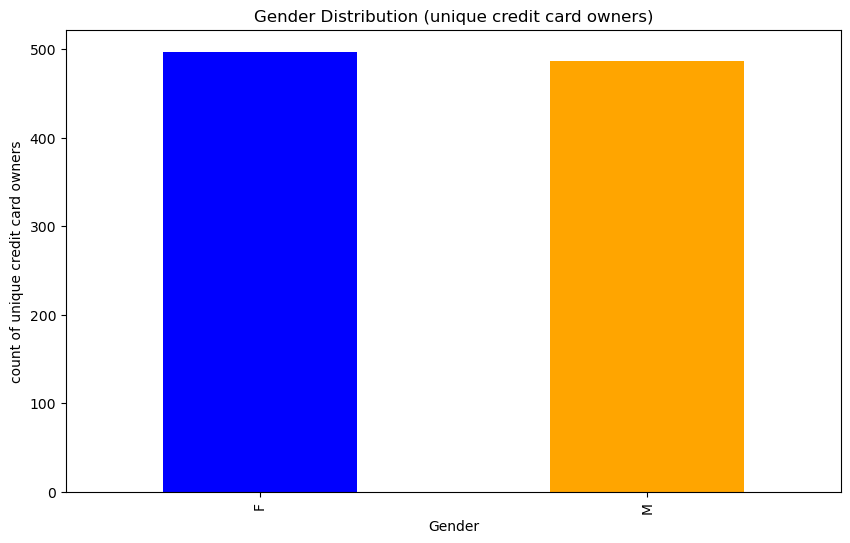

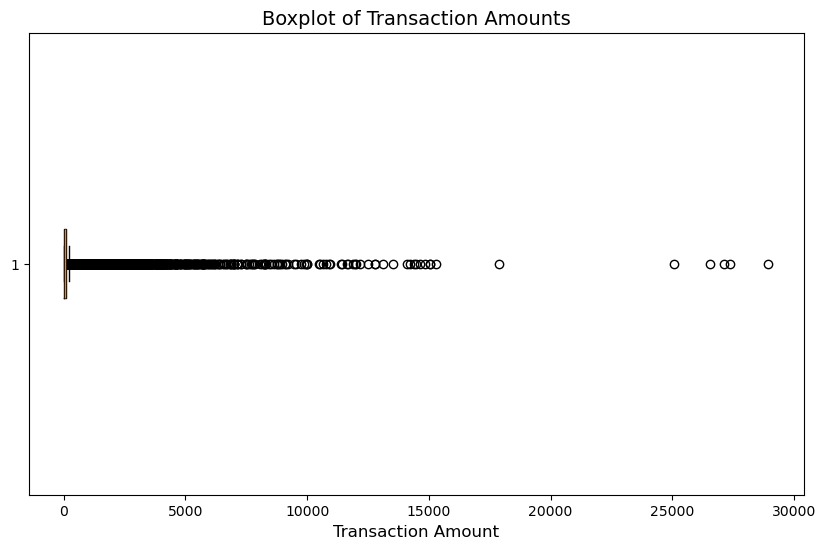

Unique Categories:
['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']
No. of Unique Categories:  14
Unique Jobs:
['Psychologist, counselling' 'Special educational needs teacher'
 'Nature conservation officer' 'Patent attorney'
 'Dance movement psychotherapist' 'Transport planner' 'Arboriculturist'
 'Designer, multimedia' 'Public affairs consultant' 'Pathologist'
 'IT trainer' 'Systems developer' 'Engineer, land' 'Systems analyst'
 'Naval architect' 'Radiographer, diagnostic'
 'Programme researcher, broadcasting/film/video' 'Energy engineer'
 'Event organiser' 'Operational researcher' 'Market researcher'
 'Probation officer' 'Leisure centre manager'
 'Corporate investment banker' 'Therapist, occupational'
 'Call centre manager' 'Police officer' 'Education officer, museum'
 'Physiotherapist' 'Network engineer' 'Forensic psychologist' 'Geochemist'
 'A

In [9]:
# Bar graph for gender distribution
gender_cc_count = fraud_train.groupby('gender')['cc_num'].nunique()

plt.figure(figsize=(10, 6))
gender_cc_count.plot(kind='bar', color=['blue', 'orange'])
plt.title('Gender Distribution (unique credit card owners)')
plt.xlabel('Gender')
plt.ylabel('count of unique credit card owners')
plt.show()

# Boxplot for transaction amounts
plt.figure(figsize=(10, 6))
plt.boxplot(fraud_train['amt'], vert=False)
plt.title('Boxplot of Transaction Amounts', fontsize=14)
plt.xlabel('Transaction Amount', fontsize=12)
plt.show()

# Print unique categories
print("Unique Categories:")
print(fraud_train['category'].unique())
print("No. of Unique Categories: ", len(fraud_train['category'].unique()))

# Print unique jobs
print("Unique Jobs:")
print(fraud_train['job'].unique())
print("No. of Unique Jobs: ", len(fraud_train['job'].unique()))

# Print dates for train and test sets
print(fraud_train['trans_date_trans_time'].head()) # eg. 2019-01-01 00:00:18

start_train_date = pd.to_datetime(fraud_train['trans_date_trans_time'].min()).date()
end_train_date = pd.to_datetime(fraud_train['trans_date_trans_time'].max()).date()
start_test_date = pd.to_datetime(fraud_test['trans_date_trans_time'].min()).date()
end_test_date = pd.to_datetime(fraud_test['trans_date_trans_time'].max()).date()

print("Train Start Date: ", start_train_date)
print("Train End Date: ", end_train_date)
print("Test Start Date: ", start_test_date)
print("Test End Date: ", end_test_date)

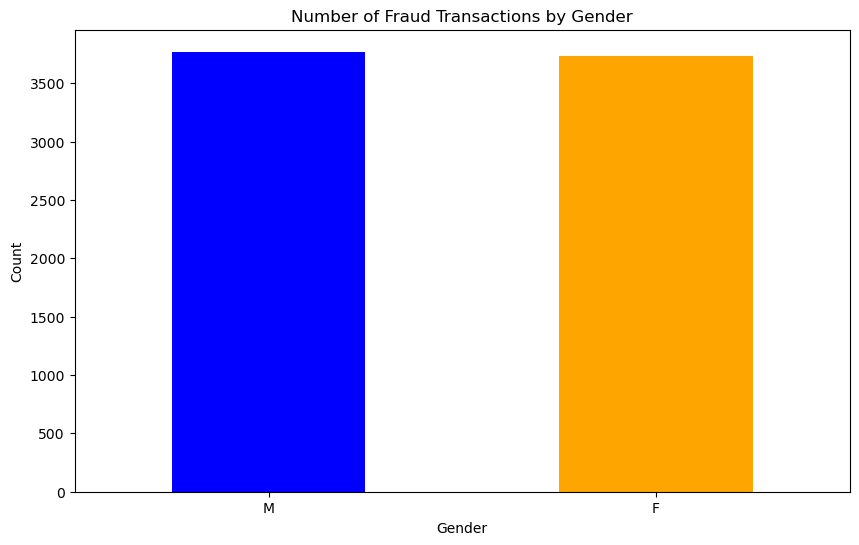

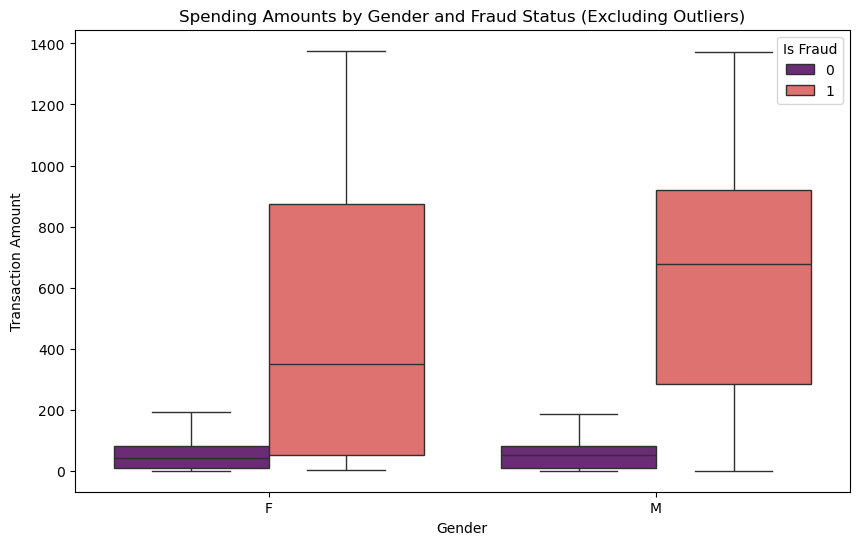

In [10]:
# Filter fraud transactions
fraud_transactions = fraud_train[fraud_train['is_fraud'] == 1]

# Group by gender and count occurrences
gender_fraud_counts = fraud_transactions['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
gender_fraud_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Fraud Transactions by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Plot spending amounts based on gender and fraud status excluding outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_train, x='gender', y='amt', hue='is_fraud', palette='magma', showfliers=False)
plt.title('Spending Amounts by Gender and Fraud Status (Excluding Outliers)')
plt.xlabel('Gender')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Fraud', loc='upper right')
plt.show()

In [11]:
# Convert gender to binary (1 for 'M' and 0 for 'F') and store in a new column 'gender_binary'
fraud_train['gender_binary'] = fraud_train['gender'].apply(lambda x: 1 if x == 'M' else 0)
fraud_test['gender_binary'] = fraud_test['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Display the updated dataframe
print(fraud_train[['gender', 'gender_binary']].head())
print(fraud_test[['gender', 'gender_binary']].head())

  gender  gender_binary
0      F              0
1      F              0
2      M              1
3      M              1
4      M              1
  gender  gender_binary
0      M              1
1      F              0
2      F              0
3      M              1
4      M              1


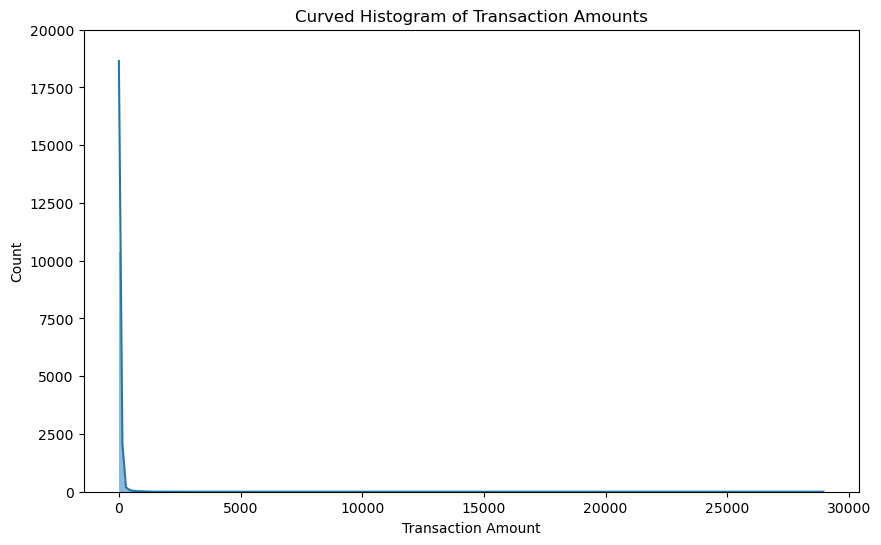

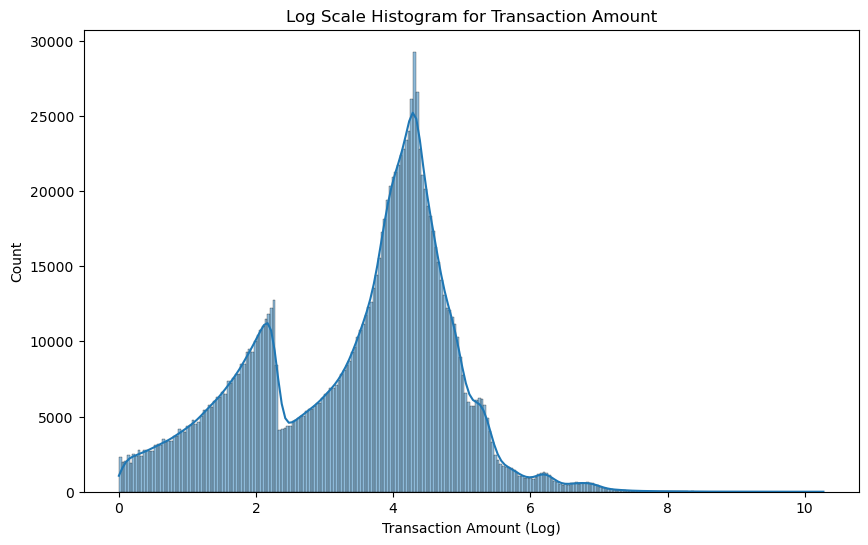

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/918405953.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=fraud_train['is_fraud'], y=np.log(fraud_train['amt']), palette='magma')


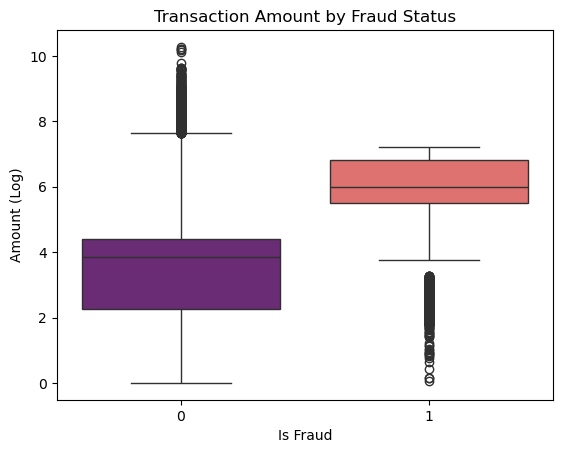

In [12]:
# Plot curved histogram for 'amt'
plt.figure(figsize=(10, 6))
sns.histplot(fraud_train['amt'], kde=True)
plt.title('Curved Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.ylim(0, 20000)
plt.show()

# Plot log scale histogram for 'amt'
plt.figure(figsize=(10, 6))
sns.histplot(np.log(fraud_train['amt']), kde=True)
plt.title('Log Scale Histogram for Transaction Amount')
plt.xlabel('Transaction Amount (Log)')
plt.ylabel('Count')
plt.show()

# plot log transaction amount by fraud status

sns.boxplot(x=fraud_train['is_fraud'], y=np.log(fraud_train['amt']), palette='magma')
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Amount (Log)')
plt.show()

In [13]:
def haversine(lat1, long1, lat2, long2):
    """computes haversine distance between a pair of coordinates"""
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(long2 - long1)
    
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c  # Distance in kilometers

fraud_train["distance"] = fraud_train.apply(lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis=1)
fraud_test["distance"] = fraud_test.apply(lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis=1)

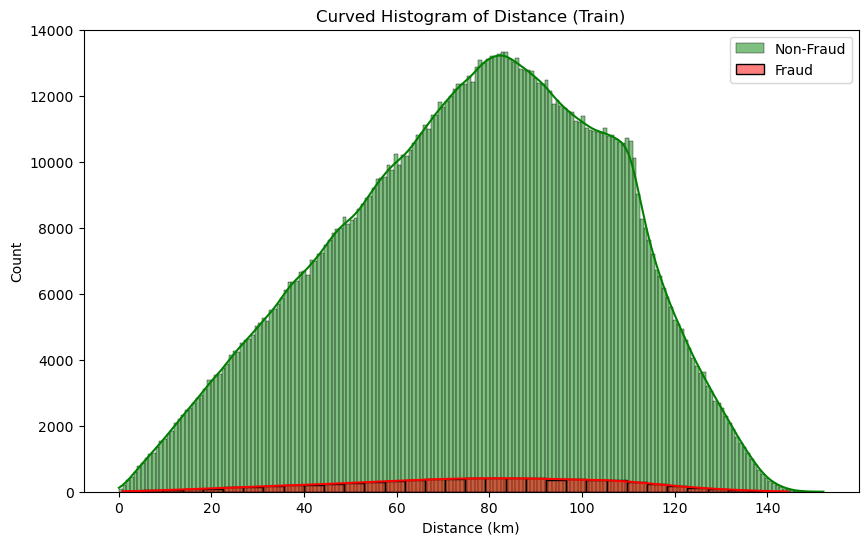

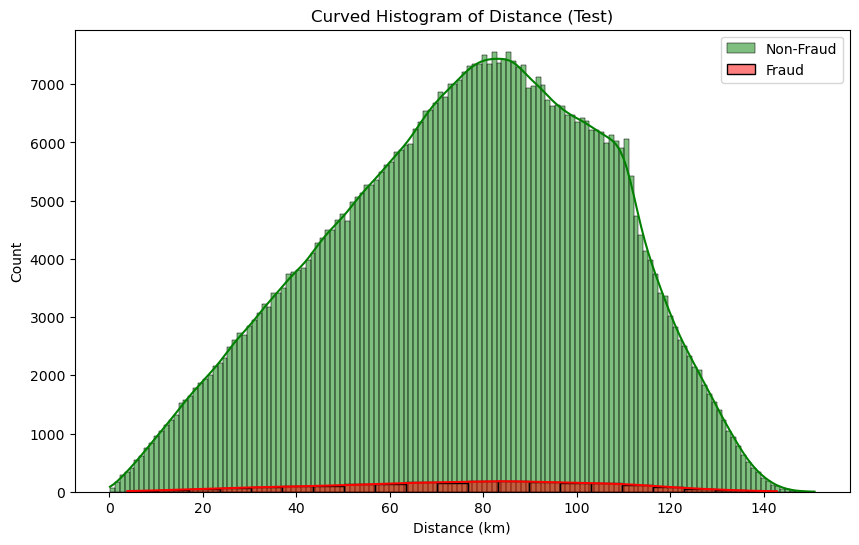

In [14]:
# plot curved histogram for distance (overlapped, not stacked)

plt.figure(figsize=(10, 6))
sns.histplot(fraud_train[fraud_train['is_fraud'] == 0]['distance'], kde=True, color='green', label='Non-Fraud')
sns.histplot(fraud_train[fraud_train['is_fraud'] == 1]['distance'], kde=True, color='red', label='Fraud')
plt.title('Curved Histogram of Distance (Train)')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(fraud_test[fraud_test['is_fraud'] == 0]['distance'], kde=True, color='green', label='Non-Fraud')
sns.histplot(fraud_test[fraud_test['is_fraud'] == 1]['distance'], kde=True, color='red', label='Fraud')
plt.title('Curved Histogram of Distance (Test)')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.legend()
plt.show()

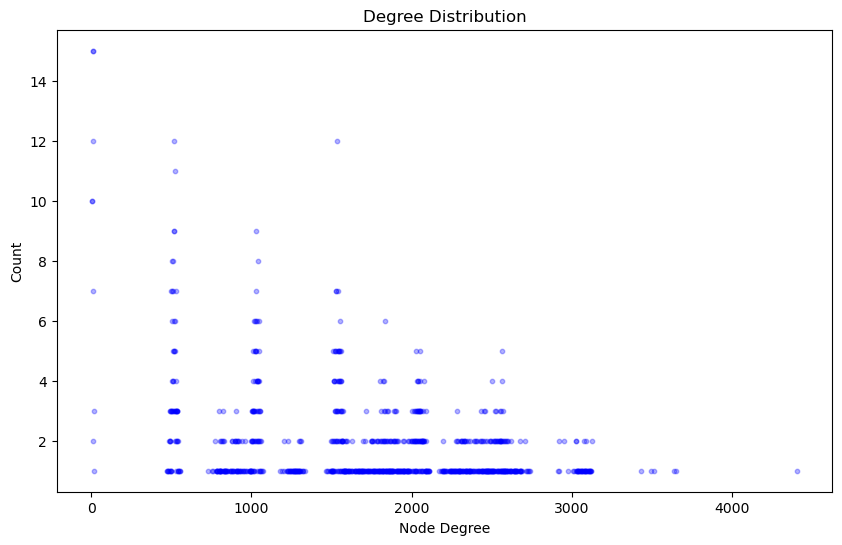

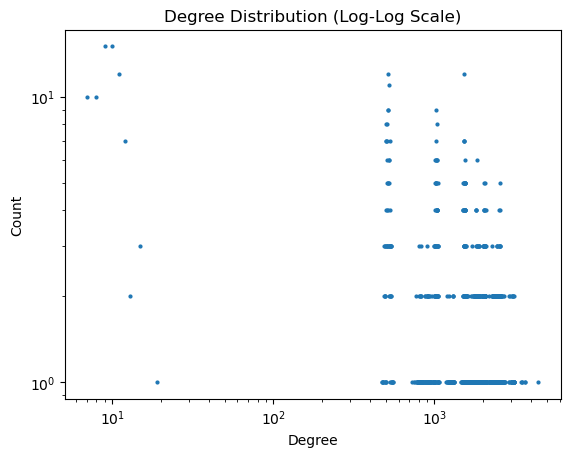

In [15]:
# Count the number of times each unique cc_num and merchant appear in the fraud_train and fraud_test dataframe
cc_num_counts_trainset = fraud_train['cc_num'].value_counts().to_dict()
merchant_counts_trainset = fraud_train['merchant'].value_counts().to_dict()
cc_num_counts_testset = fraud_test['cc_num'].value_counts().to_dict()
merchant_counts_testset = fraud_test['merchant'].value_counts().to_dict()

# Combine the two dictionaries into node_degrees
trainset_node_degrees = {**cc_num_counts_trainset, **merchant_counts_trainset}
testset_node_degrees = {**cc_num_counts_testset, **merchant_counts_testset}

degree_counts = {}

for node, degree in trainset_node_degrees.items():
  if degree in degree_counts:
    degree_counts[degree] += 1
  else:
    degree_counts[degree] = 1

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(list(degree_counts.keys()), list(degree_counts.values()), s=10, c='blue', marker='o', alpha=0.3)

# Set the title and labels
plt.title('Degree Distribution')
plt.xlabel('Node Degree')
plt.ylabel('Count')

# Show the plot
plt.show()

plt.loglog(list(degree_counts.keys()), list(degree_counts.values()), 'o', markersize=2)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution (Log-Log Scale)')
plt.show()

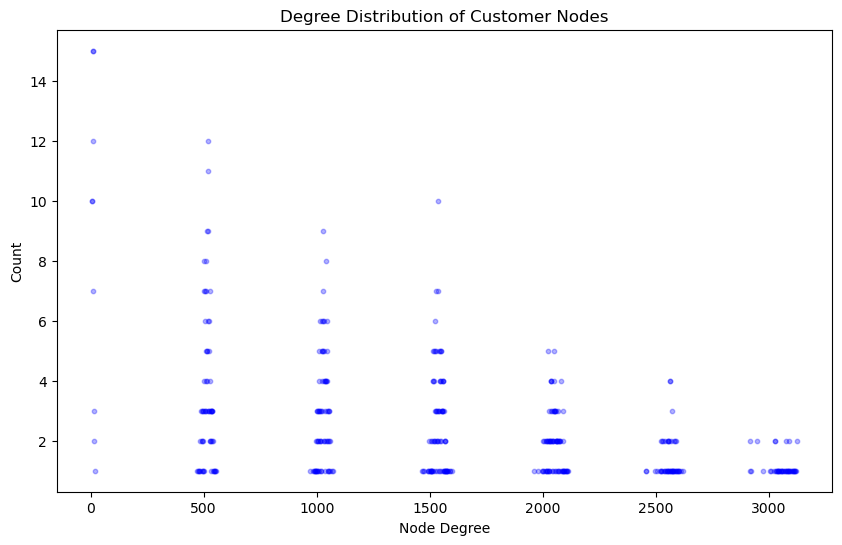

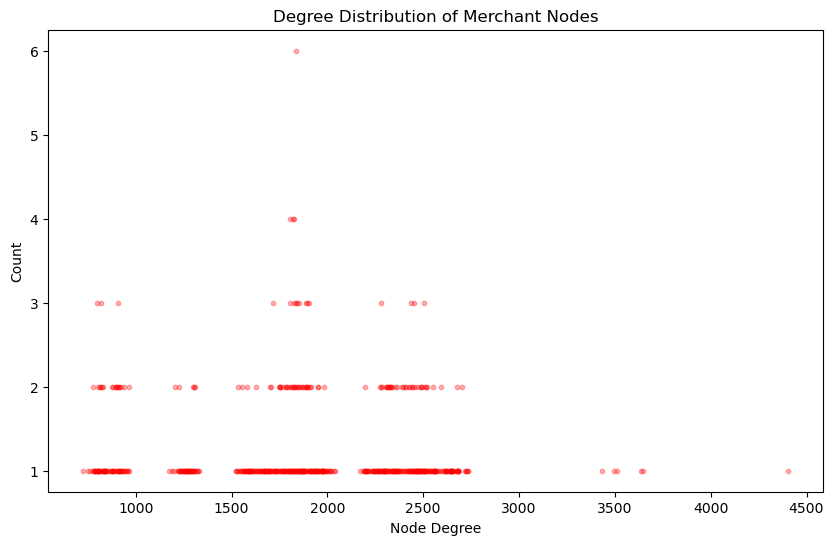

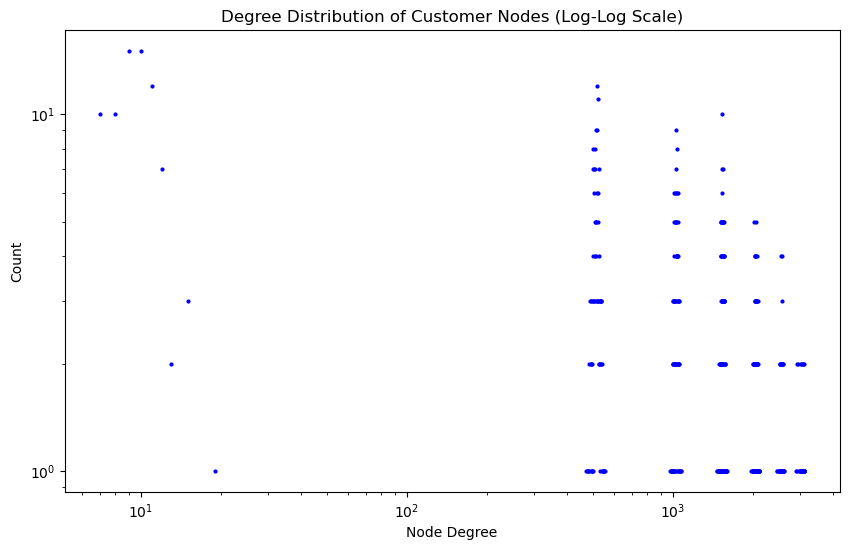

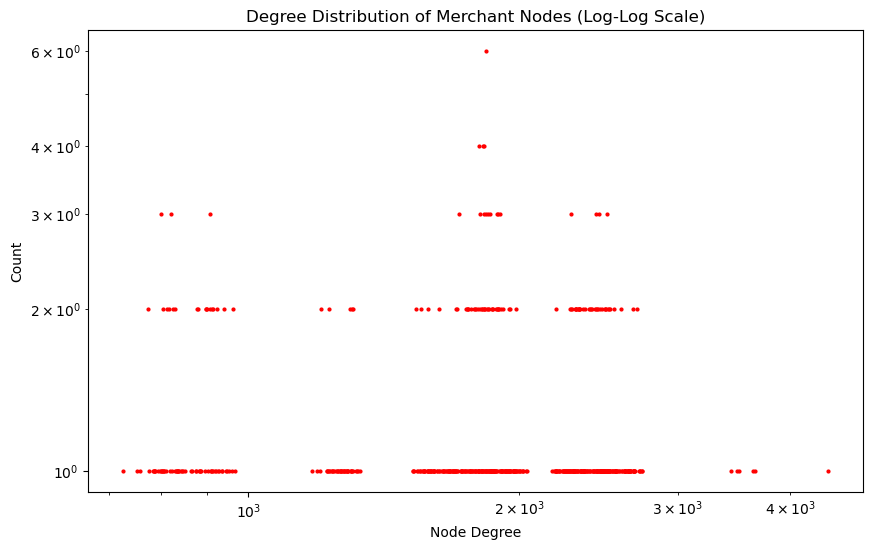

In [16]:
# Calculate degree counts for customer nodes
customer_degree_counts = {}
for _, degree in cc_num_counts_trainset.items():
    if degree in customer_degree_counts:
        customer_degree_counts[degree] += 1
    else:
        customer_degree_counts[degree] = 1

# Calculate degree counts for merchant nodes
merchant_degree_counts = {}
for _, degree in merchant_counts_trainset.items():
    if degree in merchant_degree_counts:
        merchant_degree_counts[degree] += 1
    else:
        merchant_degree_counts[degree] = 1

# Create a scatter plot for customer nodes
plt.figure(figsize=(10, 6))
plt.scatter(list(customer_degree_counts.keys()), list(customer_degree_counts.values()), s=10, c='blue', marker='o', alpha=0.3)
plt.title('Degree Distribution of Customer Nodes')
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.show()

# Create a scatter plot for merchant nodes
plt.figure(figsize=(10, 6))
plt.scatter(list(merchant_degree_counts.keys()), list(merchant_degree_counts.values()), s=10, c='red', marker='o', alpha=0.3)
plt.title('Degree Distribution of Merchant Nodes')
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.show()

# Create a log-log scale plot for customer nodes
plt.figure(figsize=(10, 6))
plt.loglog(list(customer_degree_counts.keys()), list(customer_degree_counts.values()), 'o', markersize=2, color='blue')
plt.title('Degree Distribution of Customer Nodes (Log-Log Scale)')
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.show()

# Create a log-log scale plot for merchant nodes
plt.figure(figsize=(10, 6))
plt.loglog(list(merchant_degree_counts.keys()), list(merchant_degree_counts.values()), 'o', markersize=2, color='red')
plt.title('Degree Distribution of Merchant Nodes (Log-Log Scale)')
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.show()

There is no straight line in the log-log graph, so it doesn't imply power law distribution.

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/2367166708.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='cc_num_degree_count', palette='magma')


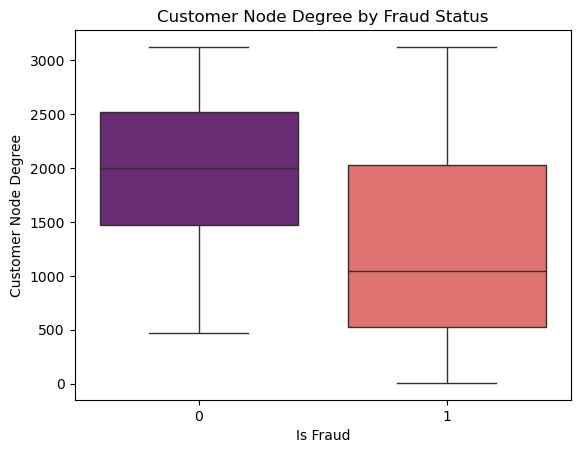

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/2367166708.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='merchant_degree_count', palette='magma')


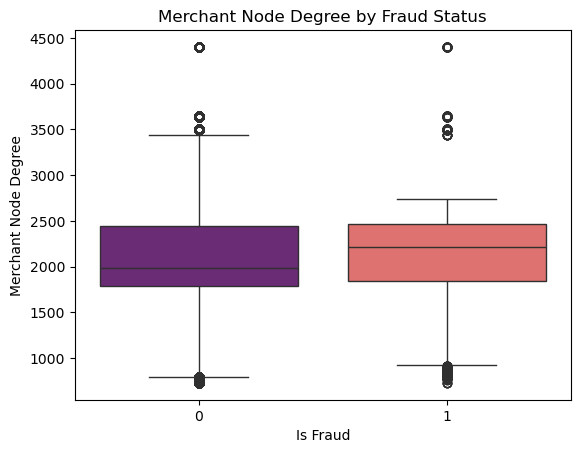

In [17]:
# Map degree counts to cc_num and merchant in the fraud_train and fraud_test datasets
fraud_train['cc_num_degree_count'] = fraud_train['cc_num'].map(trainset_node_degrees)
fraud_train['merchant_degree_count'] = fraud_train['merchant'].map(trainset_node_degrees)

fraud_test['cc_num_degree_count'] = fraud_test['cc_num'].map(testset_node_degrees)
fraud_test['merchant_degree_count'] = fraud_test['merchant'].map(testset_node_degrees)

sns.boxplot(data=fraud_train, x='is_fraud', y='cc_num_degree_count', palette='magma')
plt.title('Customer Node Degree by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Customer Node Degree')
plt.show()

sns.boxplot(data=fraud_train, x='is_fraud', y='merchant_degree_count', palette='magma')
plt.title('Merchant Node Degree by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Merchant Node Degree')
plt.show()

In [18]:
# Convert trans_date_trans_time to datetime if not already done
fraud_train['trans_date_trans_time'] = pd.to_datetime(fraud_train['trans_date_trans_time'])
fraud_test['trans_date_trans_time'] = pd.to_datetime(fraud_test['trans_date_trans_time'])

# Extract the date component
fraud_train['trans_date'] = fraud_train['trans_date_trans_time'].dt.date
fraud_test['trans_date'] = fraud_test['trans_date_trans_time'].dt.date

def get_age(dob, trans_date):
    """Calculate age based on date of birth and transaction date."""
    dob = datetime.strptime(dob, '%Y-%m-%d')  # dob is in 'YYYY-MM-DD' format
    trans_date = trans_date #datetime.strptime(row['trans_date_trans_time'], '%Y-%m-%d %H:%M:%S')
    return float(trans_date.year - dob.year)

# Calculate age from dob and trans_date for fraud_train
fraud_train['age'] = fraud_train.apply(lambda row: get_age(row['dob'], row['trans_date']), axis=1)

# Calculate age from dob and trans_date for fraud_test
fraud_test['age'] = fraud_test.apply(lambda row: get_age(row['dob'], row['trans_date']), axis=1)

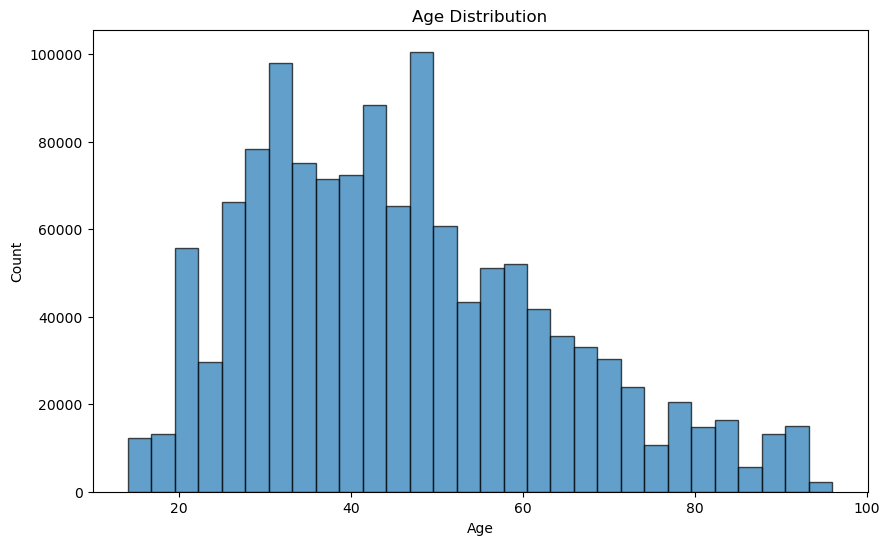

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(fraud_train['age'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<Figure size 800x500 with 0 Axes>

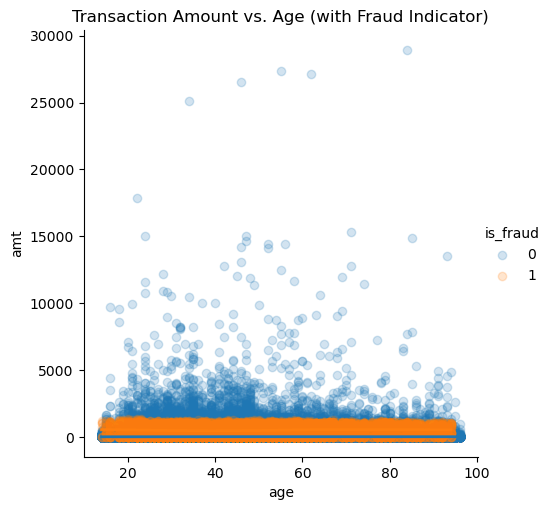

In [20]:
plt.figure(figsize=(8, 5))
sns.lmplot(
    data=fraud_train, 
    x="age", y="amt", 
    hue="is_fraud",  # Different colors for fraud vs. non-fraud
    scatter_kws={"alpha": 0.2}, 
    line_kws={"linewidth": 2}, 
    lowess=True  # LOESS smoothing
)
plt.title("Transaction Amount vs. Age (with Fraud Indicator)")
plt.show()


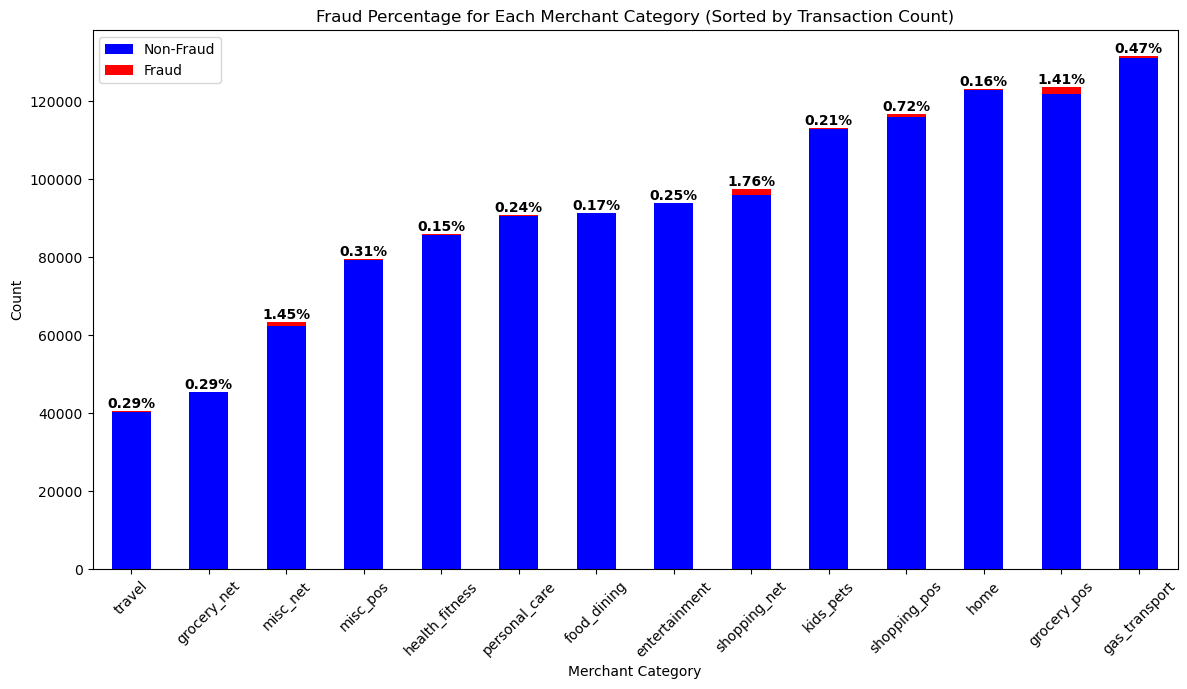

In [21]:
## percentage fraud in each merchant category

# Group by category and is_fraud, then count occurrences
category_fraud_counts = fraud_train.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

# Compute fraud percentage
fraud_percentage = category_fraud_counts[1] / (category_fraud_counts[0] + category_fraud_counts[1]) * 100

# Sort categories by total transaction count (ascending)
category_fraud_counts['total'] = category_fraud_counts.sum(axis=1)
category_fraud_counts = category_fraud_counts.sort_values(by='total', ascending=True).drop(columns=['total'])

# Plot the bar graph
ax = category_fraud_counts.plot(kind='bar', stacked=True, figsize=(14, 7), color=['blue', 'red'])

# Add fraud percentage above the bars
for i, category in enumerate(category_fraud_counts.index):
    total_non_fraud = category_fraud_counts.loc[category, 0]
    total_fraud = category_fraud_counts.loc[category, 1]
    total = total_non_fraud + total_fraud

    if total > 0:  # Avoid division by zero
        fraud_pct = fraud_percentage[category]
        ax.text(i, total + 50, f'{fraud_pct:.2f}%', ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

# Labels and title
plt.title('Fraud Percentage for Each Merchant Category (Sorted by Transaction Count)')
plt.xlabel('Merchant Category')
plt.ylabel('Count')
plt.legend(['Non-Fraud', 'Fraud'])
plt.xticks(rotation=45)
plt.show()


### Time analysis

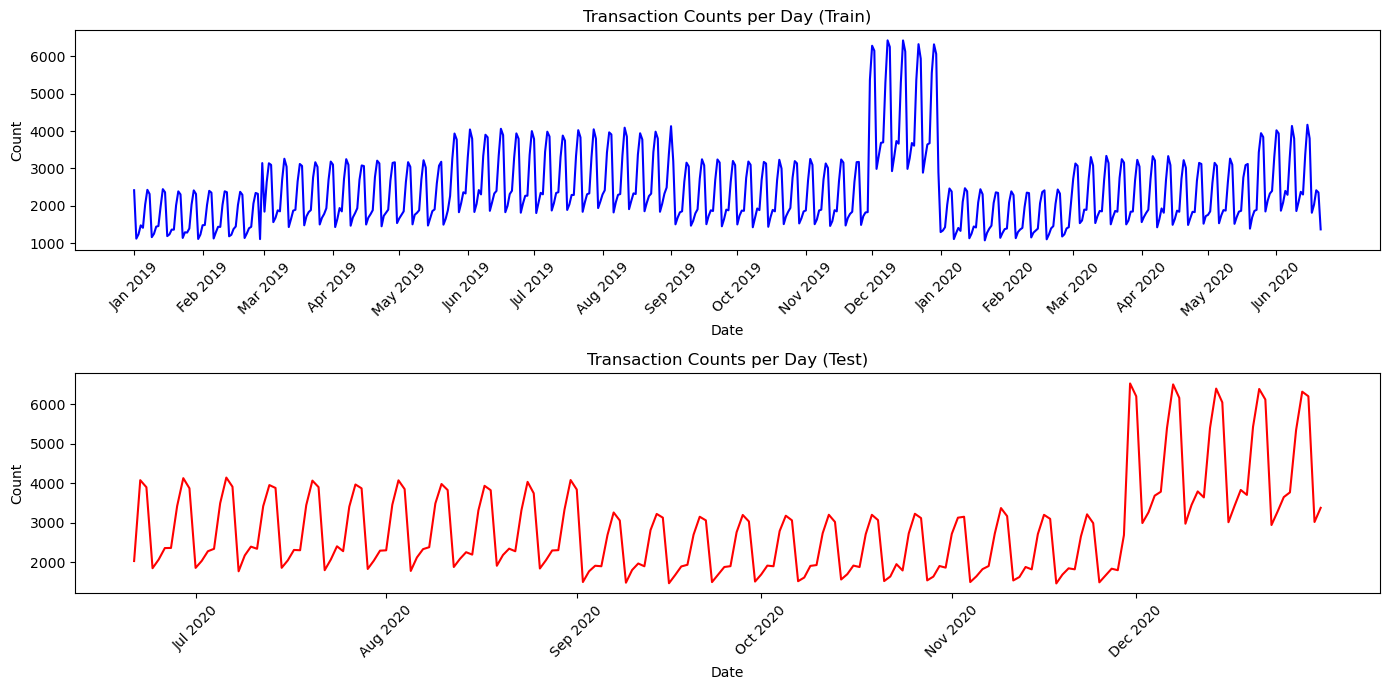

In [22]:
# Group by date and count the number of transactions
train_counts = fraud_train.groupby('trans_date').size()
test_counts = fraud_test.groupby('trans_date').size()

# Plot the counts
plt.figure(figsize=(14, 7))

# Plot for fraud_train
plt.subplot(2, 1, 1)
train_counts.plot(kind='line', color='blue')
plt.title('Transaction Counts per Day (Train)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(pd.date_range(start=start_train_date, end=end_train_date, freq='MS'), rotation=45)
plt.gca().set_xticklabels([date.strftime('%b %Y') for date in pd.date_range(start=start_train_date, end=end_train_date, freq='MS')])

# Plot for fraud_test
plt.subplot(2, 1, 2)
test_counts.plot(kind='line', color='red')
plt.title('Transaction Counts per Day (Test)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(pd.date_range(start=start_test_date, end=end_test_date, freq='MS'), rotation=45)
plt.gca().set_xticklabels([date.strftime('%b %Y') for date in pd.date_range(start=start_test_date, end=end_test_date, freq='MS')])

plt.tight_layout()
plt.show()

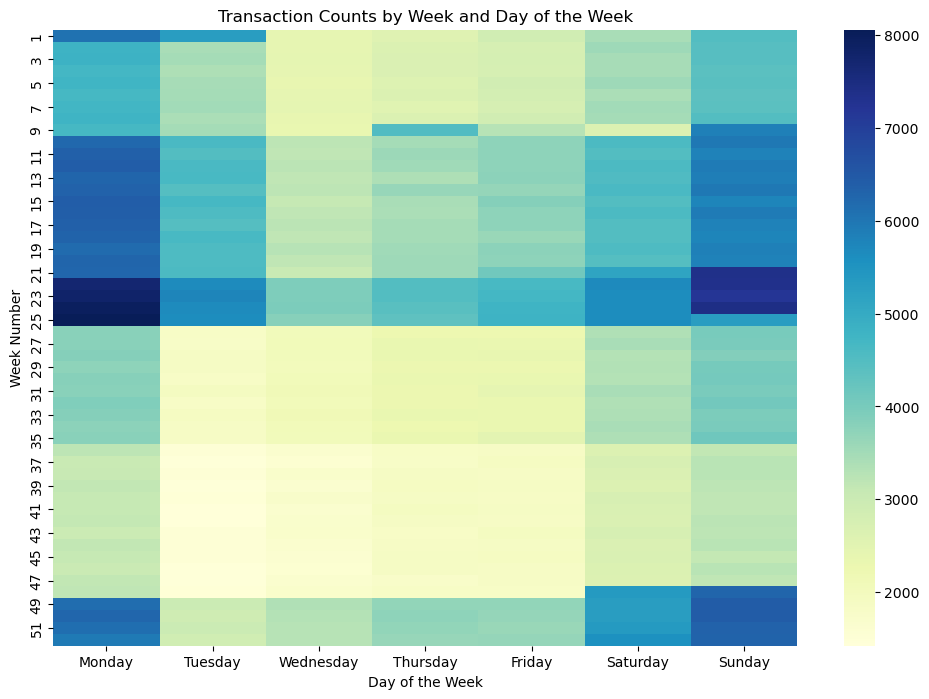

In [23]:
# Create a pivot table to count transactions by week and day of the week
fraud_train['week'] = fraud_train['trans_date_trans_time'].dt.isocalendar().week
fraud_train['day_of_week'] = fraud_train['trans_date_trans_time'].dt.day_name()
fraud_test['week'] = fraud_test['trans_date_trans_time'].dt.isocalendar().week
fraud_test['day_of_week'] = fraud_test['trans_date_trans_time'].dt.day_name()

# Pivot table to get the count of transactions
pivot_table = fraud_train.pivot_table(index='week', columns='day_of_week', values='trans_num', aggfunc='count')

# Reorder the columns to have days of the week in order
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Plot the heatmap without text annotations
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False)
plt.title('Transaction Counts by Week and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Week Number')
plt.show()

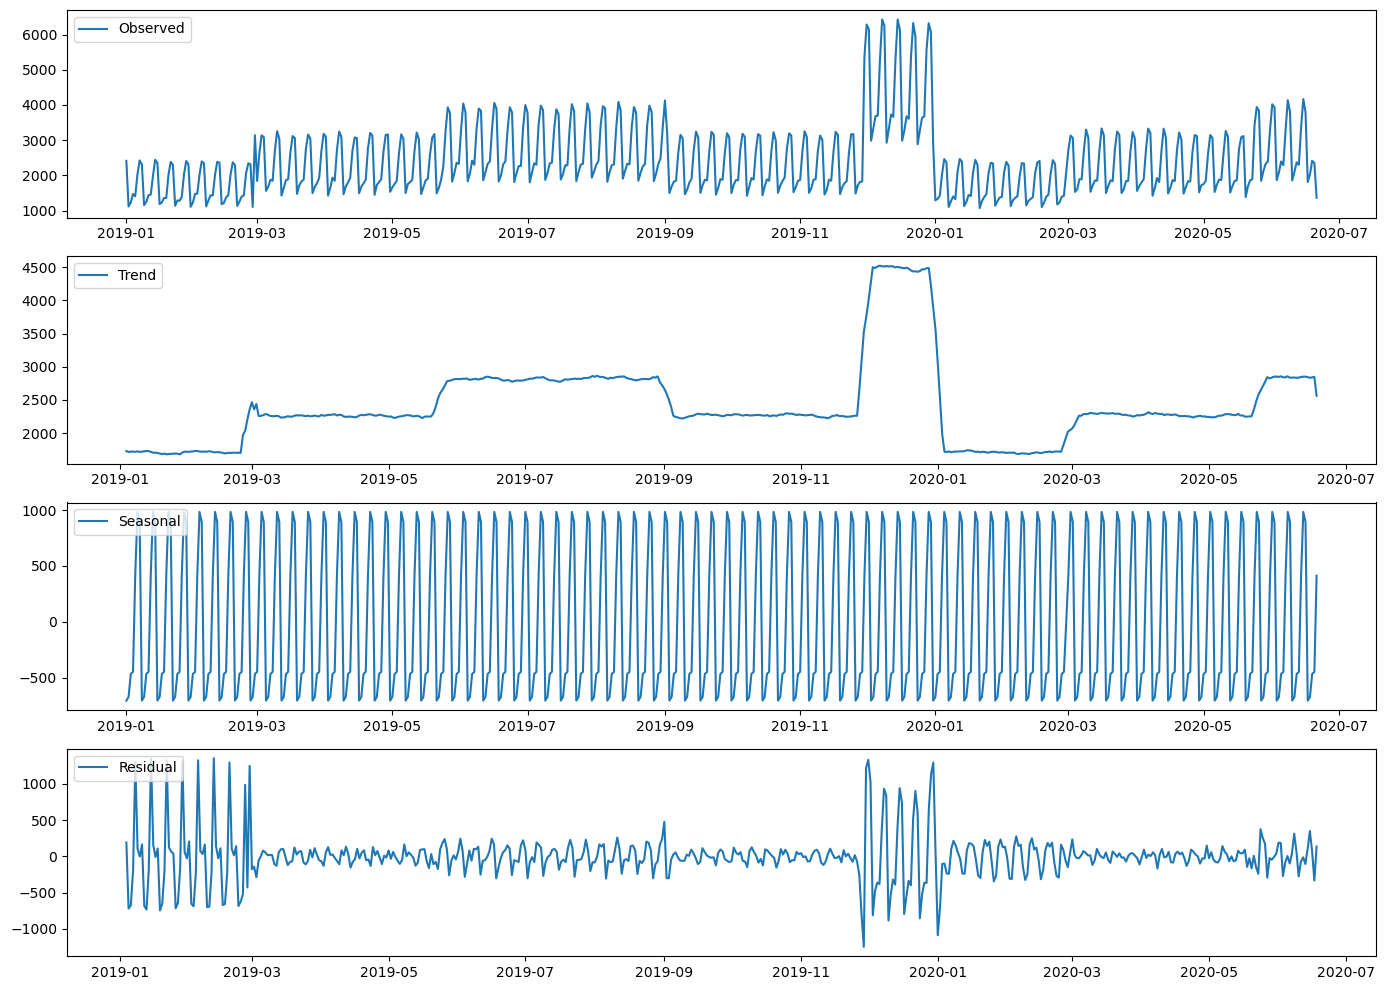

In [24]:
# Ensure the 'trans_date' column is in datetime format
fraud_train['trans_date'] = pd.to_datetime(fraud_train['trans_date'])

# Group by date and count the number of transactions
daily_counts = fraud_train.groupby('trans_date').size()

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_counts, model='additive', period=7)

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

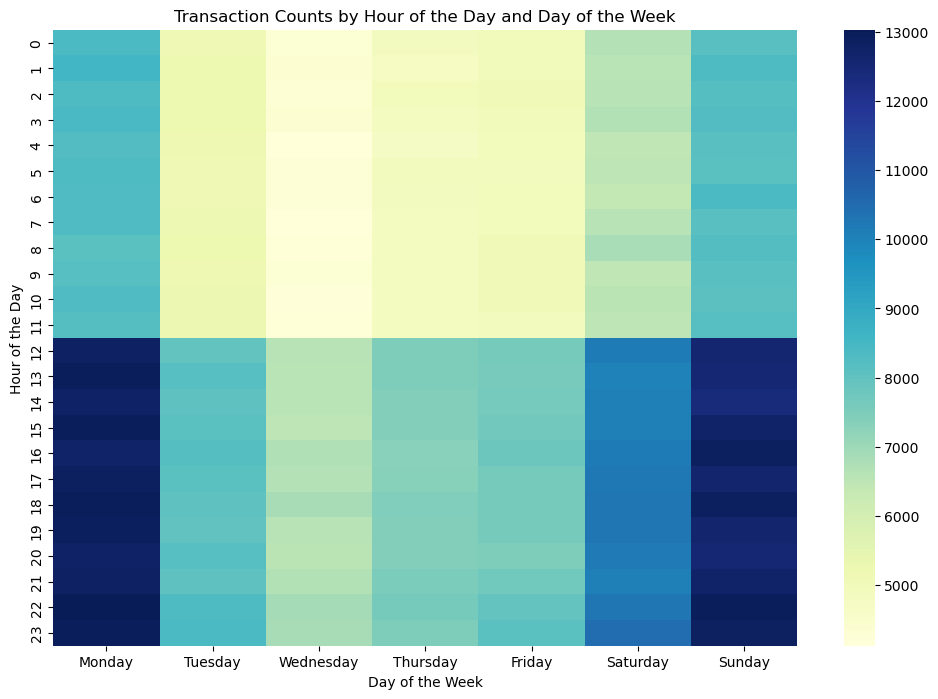

In [25]:
# Add a column for the hour of the transaction
fraud_train['trans_hour'] = fraud_train['trans_date_trans_time'].dt.hour
fraud_test['trans_hour'] = fraud_test['trans_date_trans_time'].dt.hour

# Create a pivot table to count transactions by hour and day of the week
pivot_table_hour_day = fraud_train.pivot_table(index='trans_hour', columns='day_of_week', values='trans_num', aggfunc='count')

# Reorder the columns to have days of the week in order
pivot_table_hour_day = pivot_table_hour_day[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_hour_day, cmap='YlGnBu', annot=False, fmt='d')
plt.title('Transaction Counts by Hour of the Day and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

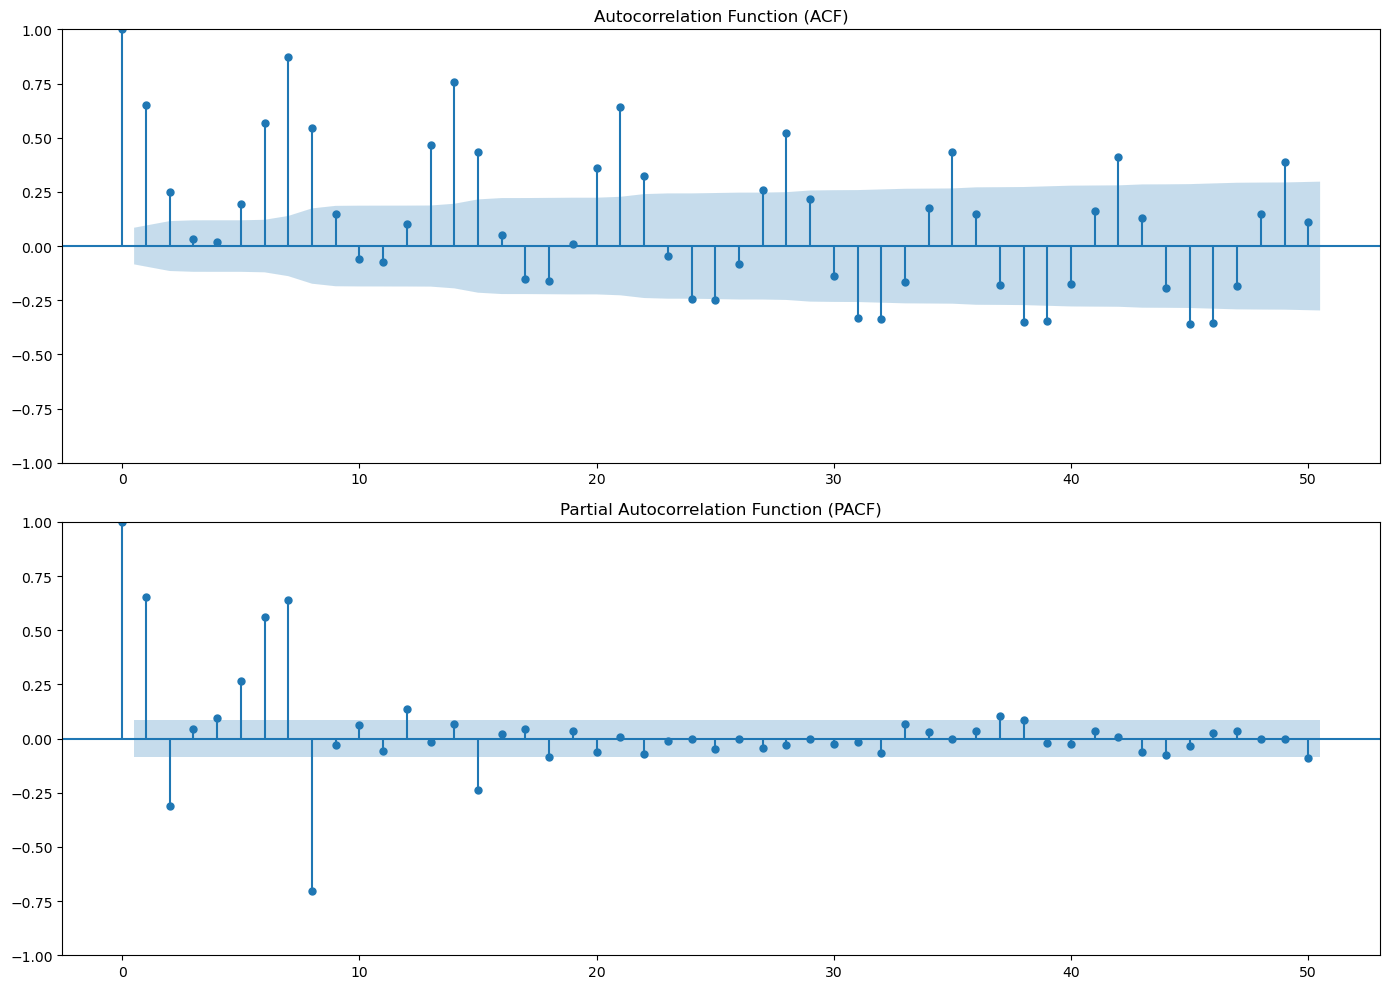

ADF p-value after seasonal differencing by 7 days: 4.6193757959515094e-07


In [26]:
# Plot ACF and PACF for daily transaction counts
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
plot_acf(daily_counts, ax=ax[0], lags=50)
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(daily_counts, ax=ax[1], lags=50)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()
# Perform seasonal differencing by 7 days
seasonal_diff = daily_counts.diff(7).dropna()

# Apply the Augmented Dickey-Fuller test
adf_result = adfuller(seasonal_diff)

# Extract and print the p-value
p_value = adf_result[1]
print(f'ADF p-value after seasonal differencing by 7 days: {p_value}')

The acf plot shows significant spikes at multiples of 7. After applying seasonal differencing by 7 days, the augmented dickey fuller (adf) test gives a small p-value of $4.6\times 10^{-7}$, telling us that the time series is stationary after seasonal differencing.

In [27]:
# Convert day_of_week to numerical values (Monday=1, ..., Sunday=7)
fraud_train['day_of_week'] = fraud_train['day_of_week'].map({
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
})
fraud_test['day_of_week'] = fraud_test['day_of_week'].map({
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
})

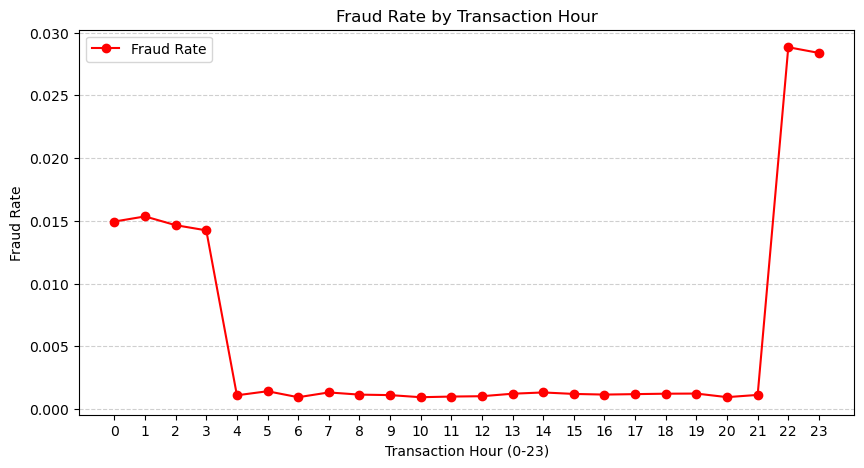

In [28]:
# Create a DataFrame for transaction hour vs fraud occurrence
# no. of fraudulent transactions at hour h / no. of transactions at hour h
hourly_fraud_trend = fraud_train.groupby("trans_hour")["is_fraud"].mean()

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(hourly_fraud_trend.index, hourly_fraud_trend.values, marker="o", linestyle="-", color="red", label="Fraud Rate")
plt.xlabel("Transaction Hour (0-23)")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Transaction Hour")
plt.xticks(range(0, 24))  # Ensure all hours are visible
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

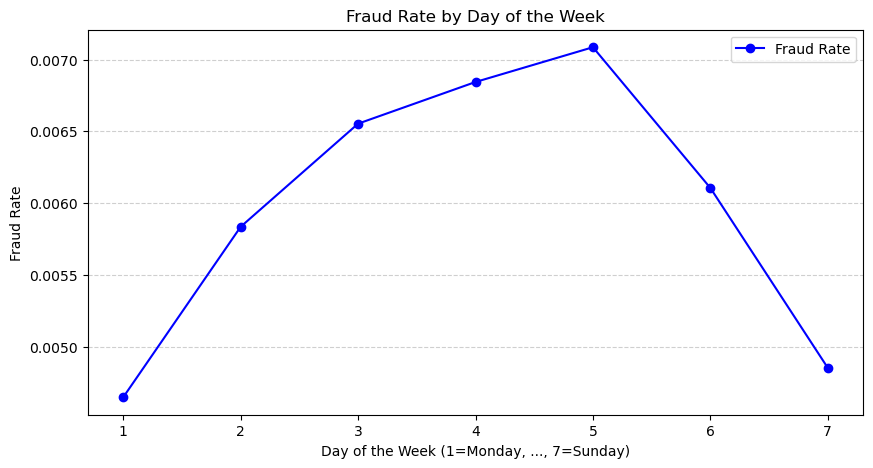

In [29]:
# Create a DataFrame for day of the week vs fraud occurrence
# no. of fraudulent transactions on day d / no. of transactions on day d
daily_fraud_trend = fraud_train.groupby("day_of_week")["is_fraud"].mean()

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(daily_fraud_trend.index, daily_fraud_trend.values, marker="o", linestyle="-", color="blue", label="Fraud Rate")
plt.xlabel("Day of the Week (1=Monday, ..., 7=Sunday)")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Day of the Week")
plt.xticks(range(1, 8))  # Ensure all days are visible
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [30]:
# is_late_night binary column (trans_hour=22-3)
fraud_train['is_late_night'] = fraud_train['trans_hour'].apply(lambda x: 1.0 if x <= 3 or x >= 22 else 0.0)
fraud_test['is_late_night'] = fraud_test['trans_hour'].apply(lambda x: 1.0 if x <= 3 or x >= 22 else 0.0)

In [31]:
# cyclical encoding for hour and day of week

fraud_train['hour_sin'] = np.sin(2 * np.pi * fraud_train['trans_hour'] / 24)
fraud_train['hour_cos'] = np.cos(2 * np.pi * fraud_train['trans_hour'] / 24)
fraud_test['hour_sin'] = np.sin(2 * np.pi * fraud_test['trans_hour'] / 24)
fraud_test['hour_cos'] = np.cos(2 * np.pi * fraud_test['trans_hour'] / 24)

fraud_train['day_sin'] = np.sin(2 * np.pi * fraud_train['day_of_week'] / 7)
fraud_train['day_cos'] = np.cos(2 * np.pi * fraud_train['day_of_week'] / 7)
fraud_test['day_sin'] = np.sin(2 * np.pi * fraud_test['day_of_week'] / 7)
fraud_test['day_cos'] = np.cos(2 * np.pi * fraud_test['day_of_week'] / 7)

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/2333037717.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='count_last24h', palette='magma')
/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/2333037717.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='count_last7days', palette='magma')
/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/2333037717.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is

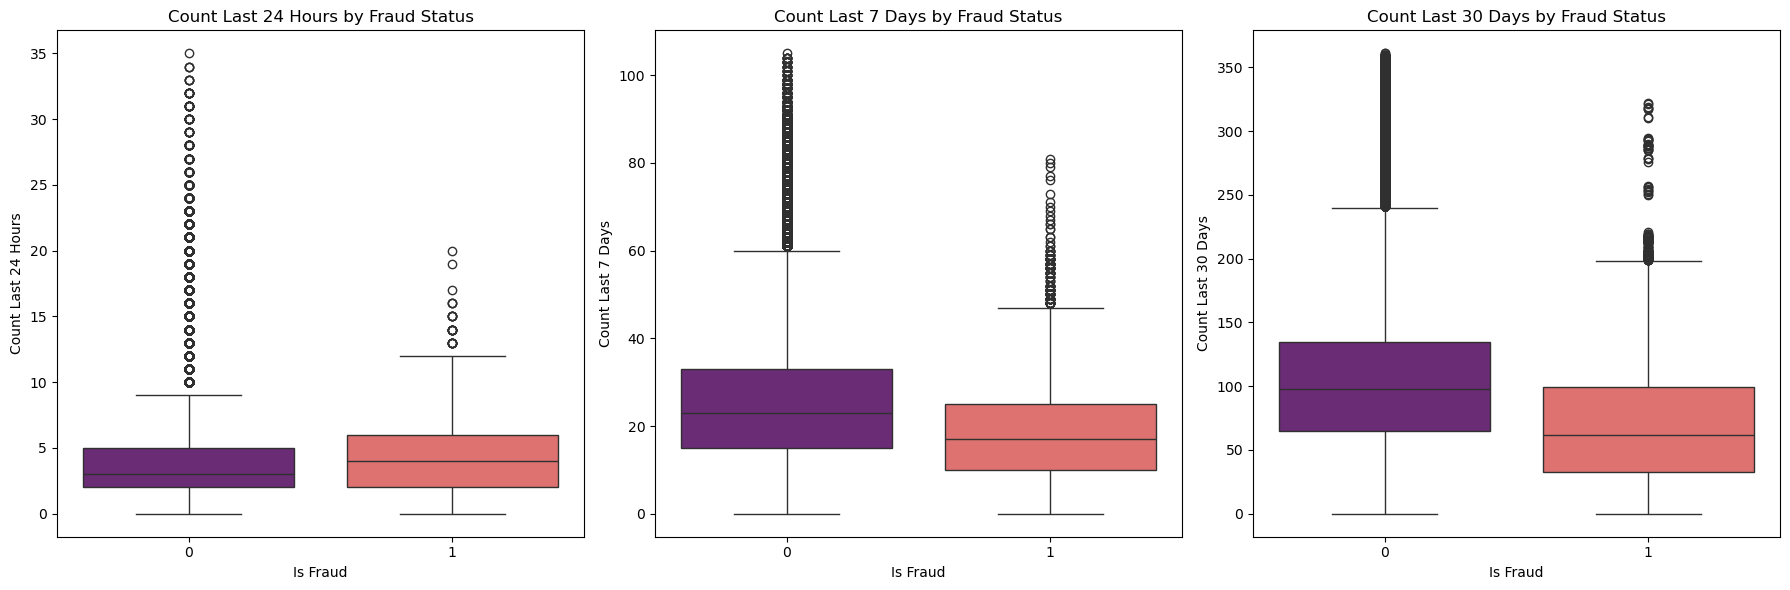

In [32]:
# Plot boxplots for count_last24h, count_last7days, and count_last30days grouped by is_fraud
plt.figure(figsize=(18, 6))

# Boxplot for count_last24h
plt.subplot(1, 3, 1)
sns.boxplot(data=fraud_train, x='is_fraud', y='count_last24h', palette='magma')
plt.title('Count Last 24 Hours by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Count Last 24 Hours')

# Boxplot for count_last7days
plt.subplot(1, 3, 2)
sns.boxplot(data=fraud_train, x='is_fraud', y='count_last7days', palette='magma')
plt.title('Count Last 7 Days by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Count Last 7 Days')

# Boxplot for count_last30days
plt.subplot(1, 3, 3)
sns.boxplot(data=fraud_train, x='is_fraud', y='count_last30days', palette='magma')
plt.title('Count Last 30 Days by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Count Last 30 Days')

plt.tight_layout()
plt.show()

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/3634195333.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 0]['count_last24h'], label="Not Fraud", shade=True)
/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/3634195333.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 1]['count_last24h'], label="Fraud", shade=True)
/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/3634195333.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 0]['count_last7days'], labe

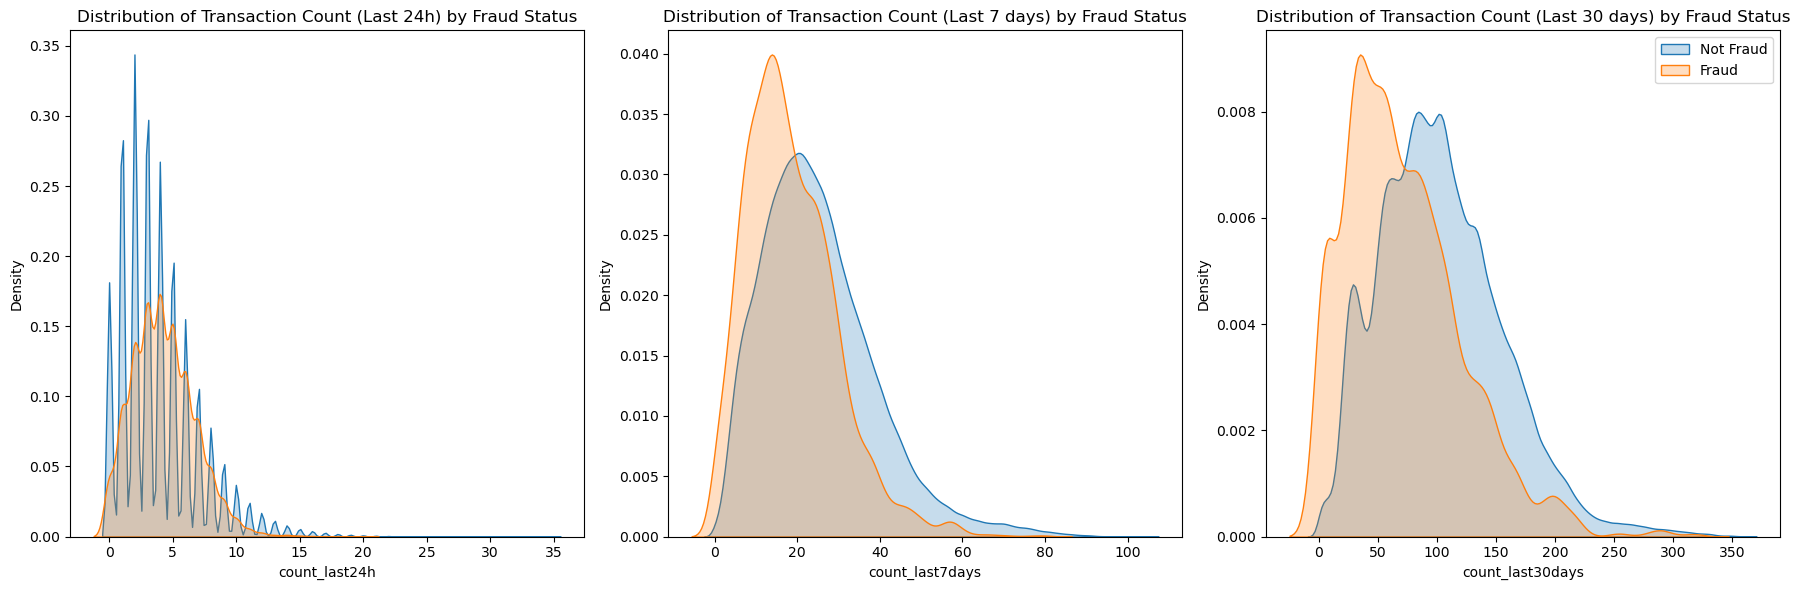

In [33]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 0]['count_last24h'], label="Not Fraud", shade=True)
sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 1]['count_last24h'], label="Fraud", shade=True)
plt.title("Distribution of Transaction Count (Last 24h) by Fraud Status")

plt.subplot(1, 3, 2)
sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 0]['count_last7days'], label="Not Fraud", shade=True)
sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 1]['count_last7days'], label="Fraud", shade=True)
plt.title("Distribution of Transaction Count (Last 7 days) by Fraud Status")

plt.subplot(1, 3, 3)
sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 0]['count_last30days'], label="Not Fraud", shade=True)
sns.kdeplot(fraud_train[fraud_train['is_fraud'] == 1]['count_last30days'], label="Fraud", shade=True)
plt.title("Distribution of Transaction Count (Last 30 days) by Fraud Status")

plt.tight_layout()
plt.legend()
plt.show()

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/3661718021.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='past_count_with_merchant', palette='magma')


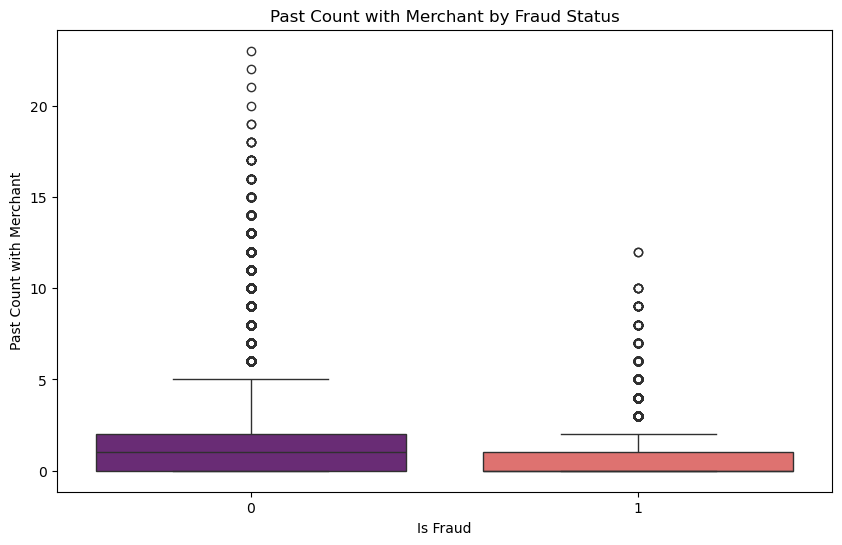

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/3661718021.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='past_count_with_merchant', palette='magma', showfliers=False)


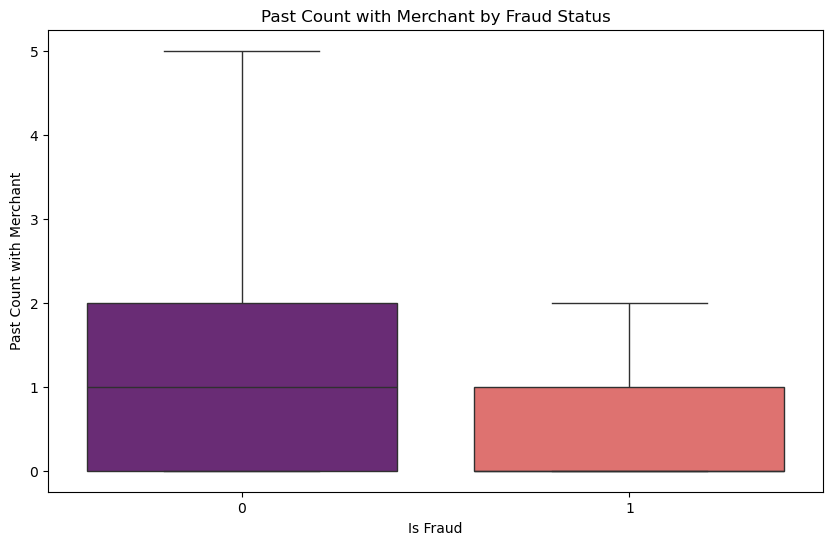

count    7506.000000
mean        0.994804
std         1.466790
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        12.000000
Name: past_count_with_merchant, dtype: float64
count    1.289169e+06
mean     1.508279e+00
std      1.768999e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.300000e+01
Name: past_count_with_merchant, dtype: float64


In [256]:
# frequency with each merchant
# fraud_train[['cc_num', 'merchant', 'past_count_with_merchant']]
# fraud_train['past_count_with_merchant'].max()
# Boxplot for past_count_with_merchant by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_train, x='is_fraud', y='past_count_with_merchant', palette='magma')
plt.title('Past Count with Merchant by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Past Count with Merchant')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_train, x='is_fraud', y='past_count_with_merchant', palette='magma', showfliers=False)
plt.title('Past Count with Merchant by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Past Count with Merchant')
plt.show()

print(fraud_train[fraud_train['is_fraud']==1]['past_count_with_merchant'].describe())
print(fraud_train[fraud_train['is_fraud']==0]['past_count_with_merchant'].describe())

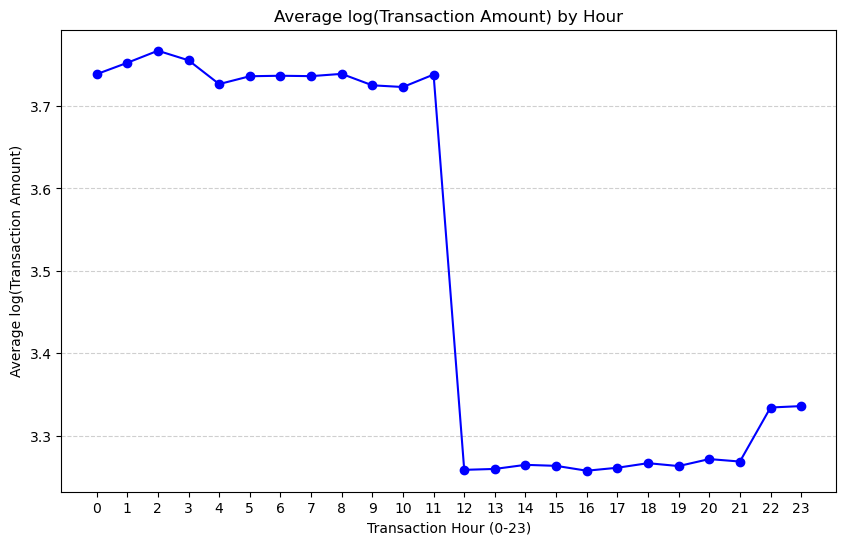

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/2947984276.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_late_night', y='log_amt', palette='magma')


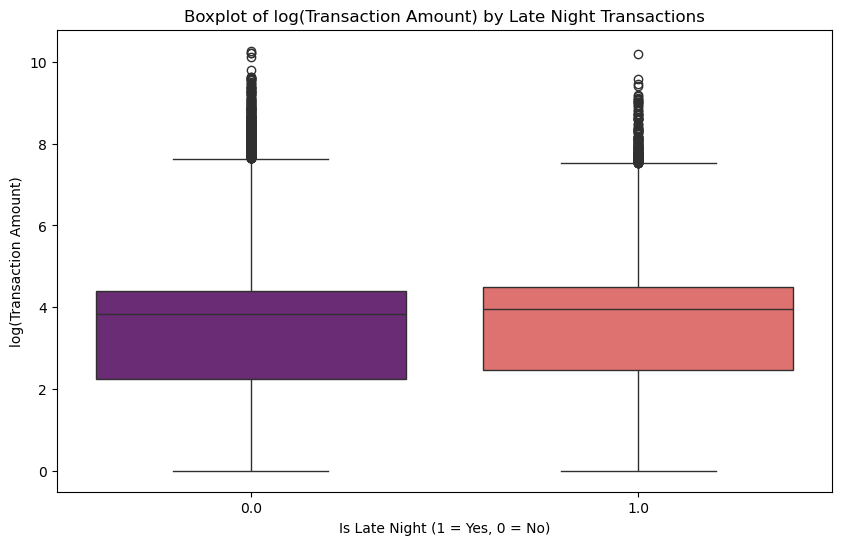

In [213]:
# Group by transaction hour and calculate the average log(amt)
avg_log_amt_per_hour = fraud_train.groupby('trans_hour')['log_amt'].mean()

# Plot the average log(amt) for each hour
plt.figure(figsize=(10, 6))
plt.plot(avg_log_amt_per_hour.index, avg_log_amt_per_hour.values, marker='o', linestyle='-', color='blue')
plt.title('Average log(Transaction Amount) by Hour')
plt.xlabel('Transaction Hour (0-23)')
plt.ylabel('Average log(Transaction Amount)')
plt.xticks(range(0, 24))  # Ensure all hours are visible
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Boxplot of log(Transaction Amount) grouped by is_late_night
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_train, x='is_late_night', y='log_amt', palette='magma')
plt.title('Boxplot of log(Transaction Amount) by Late Night Transactions')
plt.xlabel('Is Late Night (1 = Yes, 0 = No)')
plt.ylabel('log(Transaction Amount)')
plt.show()

### Geographical analysis

In [ ]:
# Create a base map centered at an approximate world center (e.g., lat=0, long=0)
train_map = folium.Map(location=[0, 0], zoom_start=2)

locations = fraud_train[['lat', 'long']].values.tolist() + fraud_train[['merch_lat', 'merch_long']].values.tolist()
HeatMap(locations).add_to(train_map)

# Save the map to an HTML file
train_map.save("world_heat_map_train.html")

In [ ]:
# sample some data points and plot customer-merchant distance

sample_size = 500

fraud_sample = fraud_train[fraud_train["is_fraud"] == 1].sample(n=sample_size//2, random_state=4288)
non_fraud_sample = fraud_train[fraud_train["is_fraud"] == 0].sample(n=sample_size//2, random_state=4288)

sampled_data = pd.concat([fraud_sample, non_fraud_sample])

m = folium.Map(location=[fraud_train['lat'].mean(), fraud_train['long'].mean()], zoom_start=5)

for _, row in sampled_data.iterrows():
    color = "red" if row["is_fraud"] == 1 else "green"
    
    # Add customer location
    folium.CircleMarker(
        location=[row["lat"], row["long"]],
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

    # Add merchant location
    folium.CircleMarker(
        location=[row["merch_lat"], row["merch_long"]],
        radius=3,
        color="black",  # Merchants in green
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

    # Draw a line between them (distance visualization)
    folium.PolyLine(
        [(row["lat"], row["long"]), (row["merch_lat"], row["merch_long"])],
        color=color,
        weight=3,
        opacity=0.5
    ).add_to(m)

legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 120px;
            background-color: white; z-index:9999; padding: 10px; font-size:14px;
            border-radius: 5px; box-shadow: 0px 0px 5px rgba(0,0,0,0.5); opacity: 0.9;">
    <b>Legend</b><br>
    <svg width="20" height="10"><line x1="0" y1="5" x2="20" y2="5" style="stroke:red;stroke-width:3"/></svg> Fraud <br>
    <svg width="20" height="10"><line x1="0" y1="5" x2="20" y2="5" style="stroke:green;stroke-width:3"/></svg> Non-Fraud <br>
    <i style="background:blue;width:10px;height:10px;border-radius:50%;display:inline-block;"></i> Customer <br>
    <i style="background:black;width:10px;height:10px;border-radius:50%;display:inline-block;"></i> Merchant <br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Save map to HTML file
m.save("customer_merchant_distance_colour_frauds_train.html")

In [ ]:
eg_customer_id = 4613314721966 # has fraudulent activity
eg_customer_df = fraud_train[fraud_train["cc_num"] == eg_customer_id]

print(eg_customer_df[['lat', 'long', 'merch_lat', 'merch_long']].head())

m = folium.Map(location=[eg_customer_df['lat'].mean(),eg_customer_df['long'].mean()], zoom_start=5)

for _, row in eg_customer_df.iterrows():
    folium.CircleMarker(
    location=[row['lat'], row['long']],
    radius=3,
    color="blue",
    fill=True,
    fill_opacity=0.6
    ).add_to(m)
    
    folium.CircleMarker(
        location=[row['merch_lat'], row['merch_long']],
        radius=3,
        color="black",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)
    
    # Line color based on is_fraud
    line_color = "red" if row["is_fraud"] == 1 else "green"
    if row['is_fraud']==0: continue

    folium.PolyLine(
        [(row["lat"], row["long"]), (row["merch_lat"], row["merch_long"])],
        color=line_color,
        weight=3,
        opacity=0.5
    ).add_to(m)

legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 120px;
            background-color: white; z-index:9999; padding: 10px; font-size:14px;
            border-radius: 5px; box-shadow: 0px 0px 5px rgba(0,0,0,0.5); opacity: 0.9;">
    <b>Legend</b><br>
    <svg width="20" height="10"><line x1="0" y1="5" x2="20" y2="5" style="stroke:red;stroke-width:3"/></svg> Fraud <br>
    <svg width="20" height="10"><line x1="0" y1="5" x2="20" y2="5" style="stroke:green;stroke-width:3"/></svg> Non-Fraud <br>
    <i style="background:blue;width:10px;height:10px;border-radius:50%;display:inline-block;"></i> Customer <br>
    <i style="background:black;width:10px;height:10px;border-radius:50%;display:inline-block;"></i> Merchant <br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# save map to html file
m.save("example_customer_map.html")

          lat     long  merch_lat  merch_long
1023  35.9946 -81.7266  35.773439  -80.895816
2449  35.9946 -81.7266  36.430124  -81.179483
2546  35.9946 -81.7266  35.909292  -82.091010
2937  35.9946 -81.7266  35.987802  -81.254332
3527  35.9946 -81.7266  35.985612  -81.383306


## categorise jobs in fraud_train and fraud_test

method:
- using DeepSeek, categorise the unique jobs to one of 13 categories.
- then create a job to job category mapping and add this job category to the data frame

In [35]:
unique_train_jobs = set(fraud_train['job'].unique())
unique_test_jobs = set(fraud_test['job'].unique())
unique_jobs = unique_train_jobs | unique_test_jobs

In [36]:
job_categories = ["Education & Training", "Healthcare & Medicine", "Engineering", "Technology & IT", "Science & Research", 
                  "Creative Arts & Design", "Legal & Law Enforcement", "Business & Finance", "Environment & Agriculture", 
                  "Government & Public Services", "Social Services & Non-Profit", "Media & Communications", "Hospitality, Tourism & Events"]

# Create a dictionary to map unique jobs to job categories
job_category_mapping = {
    'Psychologist, counselling': 'Healthcare & Medicine',
    'Special educational needs teacher': 'Education & Training',
    'Nature conservation officer': 'Environment & Agriculture',
    'Patent attorney': 'Legal & Law Enforcement',
    'Dance movement psychotherapist': 'Healthcare & Medicine',
    'Transport planner': 'Engineering',
    'Arboriculturist': 'Environment & Agriculture',
    'Designer, multimedia': 'Creative Arts & Design',
    'Public affairs consultant': 'Government & Public Services',
    'Pathologist': 'Healthcare & Medicine',
    'IT trainer': 'Technology & IT',
    'Systems developer': 'Technology & IT',
    'Engineer, land': 'Engineering',
    'Systems analyst': 'Technology & IT',
    'Naval architect': 'Engineering',
    'Radiographer, diagnostic': 'Healthcare & Medicine',
    'Programme researcher, broadcasting/film/video': 'Media & Communications',
    'Energy engineer': 'Engineering',
    'Event organiser': 'Hospitality, Tourism & Events',
    'Operational researcher': 'Science & Research',
    'Market researcher': 'Business & Finance',
    'Probation officer': 'Social Services & Non-Profit',
    'Leisure centre manager': 'Hospitality, Tourism & Events',
    'Corporate investment banker': 'Business & Finance',
    'Therapist, occupational': 'Healthcare & Medicine',
    'Call centre manager': 'Business & Finance',
    'Police officer': 'Legal & Law Enforcement',
    'Education officer, museum': 'Education & Training',
    'Physiotherapist': 'Healthcare & Medicine',
    'Network engineer': 'Technology & IT',
    'Forensic psychologist': 'Healthcare & Medicine',
    'Geochemist': 'Science & Research',
    'Armed forces training and education officer': 'Education & Training',
    'Designer, furniture': 'Creative Arts & Design',
    'Optician, dispensing': 'Healthcare & Medicine',
    'Psychologist, forensic': 'Healthcare & Medicine',
    'Librarian, public': 'Education & Training',
    'Fine artist': 'Creative Arts & Design',
    'Scientist, research (maths)': 'Science & Research',
    'Research officer, trade union': 'Government & Public Services',
    'Tourism officer': 'Hospitality, Tourism & Events',
    'Human resources officer': 'Business & Finance',
    'Surveyor, minerals': 'Environment & Agriculture',
    'Applications developer': 'Technology & IT',
    'Video editor': 'Media & Communications',
    'Curator': 'Creative Arts & Design',
    'Research officer, political party': 'Government & Public Services',
    'Engineer, mining': 'Engineering',
    'Education officer, community': 'Education & Training',
    'Physicist, medical': 'Science & Research',
    'Amenity horticulturist': 'Environment & Agriculture',
    'Electrical engineer': 'Engineering',
    'Television camera operator': 'Media & Communications',
    'Higher education careers adviser': 'Education & Training',
    'Ambulance person': 'Healthcare & Medicine',
    'Dealer': 'Business & Finance',
    'Paediatric nurse': 'Healthcare & Medicine',
    'Trading standards officer': 'Legal & Law Enforcement',
    'Engineer, technical sales': 'Engineering',
    'Designer, jewellery': 'Creative Arts & Design',
    'Clinical biochemist': 'Science & Research',
    'Engineer, electronics': 'Engineering',
    'Water engineer': 'Engineering',
    'Science writer': 'Media & Communications',
    'Film/video editor': 'Media & Communications',
    'Solicitor, Scotland': 'Legal & Law Enforcement',
    'Product/process development scientist': 'Science & Research',
    'Tree surgeon': 'Environment & Agriculture',
    'Careers information officer': 'Education & Training',
    'Geologist, engineering': 'Science & Research',
    'Counsellor': 'Social Services & Non-Profit',
    'Freight forwarder': 'Business & Finance',
    'Senior tax professional/tax inspector': 'Government & Public Services',
    'Engineer, broadcasting (operations)': 'Engineering',
    'English as a second language teacher': 'Education & Training',
    'Economist': 'Business & Finance',
    'Child psychotherapist': 'Healthcare & Medicine',
    'Claims inspector/assessor': 'Business & Finance',
    'Tourist information centre manager': 'Hospitality, Tourism & Events',
    'Exhibitions officer, museum/gallery': 'Creative Arts & Design',
    'Location manager': 'Media & Communications',
    'Engineer, biomedical': 'Engineering',
    'Research scientist (physical sciences)': 'Science & Research',
    'Purchasing manager': 'Business & Finance',
    'Editor, magazine features': 'Media & Communications',
    'Operations geologist': 'Science & Research',
    'Interpreter': 'Social Services & Non-Profit',
    'Engineering geologist': 'Science & Research',
    'Agricultural consultant': 'Environment & Agriculture',
    'Paramedic': 'Healthcare & Medicine',
    'Financial adviser': 'Business & Finance',
    'Administrator, education': 'Education & Training',
    'Educational psychologist': 'Education & Training',
    'Financial trader': 'Business & Finance',
    'Audiological scientist': 'Science & Research',
    'Scientist, audiological': 'Science & Research',
    'Administrator, charities/voluntary organisations': 'Social Services & Non-Profit',
    'Health service manager': 'Healthcare & Medicine',
    'Retail merchandiser': 'Business & Finance',
    'Telecommunications researcher': 'Technology & IT',
    'Exercise physiologist': 'Healthcare & Medicine',
    'Accounting technician': 'Business & Finance',
    'Product designer': 'Creative Arts & Design',
    'Waste management officer': 'Environment & Agriculture',
    'Mining engineer': 'Engineering',
    'Surgeon': 'Healthcare & Medicine',
    'Therapist, horticultural': 'Environment & Agriculture',
    'Environmental consultant': 'Environment & Agriculture',
    'Broadcast presenter': 'Media & Communications',
    'Producer, radio': 'Media & Communications',
    'Engineer, communications': 'Engineering',
    'Historic buildings inspector/conservation officer': 'Environment & Agriculture',
    'Teacher, English as a foreign language': 'Education & Training',
    'Materials engineer': 'Engineering',
    'Health visitor': 'Healthcare & Medicine',
    'Medical secretary': 'Healthcare & Medicine',
    'Theatre director': 'Creative Arts & Design',
    'Technical brewer': 'Business & Finance',
    'Land/geomatics surveyor': 'Environment & Agriculture',
    'Engineer, structural': 'Engineering',
    'Diagnostic radiographer': 'Healthcare & Medicine',
    'Television production assistant': 'Media & Communications',
    'Medical sales representative': 'Business & Finance',
    'Building control surveyor': 'Engineering',
    'Therapist, sports': 'Healthcare & Medicine',
    'Structural engineer': 'Engineering',
    'Commercial/residential surveyor': 'Business & Finance',
    'Database administrator': 'Technology & IT',
    'Exhibition designer': 'Creative Arts & Design',
    'Training and development officer': 'Education & Training',
    'Mechanical engineer': 'Engineering',
    'Medical physicist': 'Science & Research',
    'Administrator': 'Government & Public Services',
    'Mudlogger': 'Engineering',
    'Fisheries officer': 'Environment & Agriculture',
    'Conservator, museum/gallery': 'Creative Arts & Design',
    'Programmer, multimedia': 'Technology & IT',
    'Cytogeneticist': 'Science & Research',
    'Multimedia programmer': 'Technology & IT',
    'Counselling psychologist': 'Healthcare & Medicine',
    'Chiropodist': 'Healthcare & Medicine',
    'Teacher, early years/pre': 'Education & Training',
    'Cartographer': 'Science & Research',
    'Pensions consultant': 'Business & Finance',
    'Primary school teacher': 'Education & Training',
    'Electronics engineer': 'Engineering',
    'Museum/gallery exhibitions officer': 'Creative Arts & Design',
    'Air broker': 'Business & Finance',
    'Chemical engineer': 'Engineering',
    'Advertising account executive': 'Business & Finance',
    'Advertising account planner': 'Business & Finance',
    'Chartered legal executive (England and Wales)': 'Legal & Law Enforcement',
    'Psychiatric nurse': 'Healthcare & Medicine',
    'Secondary school teacher': 'Education & Training',
    'Librarian, academic': 'Education & Training',
    'Embryologist, clinical': 'Science & Research',
    'Immunologist': 'Science & Research',
    'Television floor manager': 'Media & Communications',
    'Contractor': 'Business & Finance',
    'Health physicist': 'Science & Research',
    'Copy': 'Media & Communications',
    'Bookseller': 'Business & Finance',
    'Land': 'Environment & Agriculture',
    'Chartered loss adjuster': 'Business & Finance',
    'Occupational psychologist': 'Healthcare & Medicine',
    'Facilities manager': 'Business & Finance',
    'Further education lecturer': 'Education & Training',
    'Archivist': 'Education & Training',
    'Investment analyst': 'Business & Finance',
    'Engineer, building services': 'Engineering',
    'Psychologist, sport and exercise': 'Healthcare & Medicine',
    'Journalist, newspaper': 'Media & Communications',
    'Doctor, hospital': 'Healthcare & Medicine',
    'Phytotherapist': 'Healthcare & Medicine',
    'Pharmacologist': 'Science & Research',
    'Horticultural therapist': 'Environment & Agriculture',
    'Hydrologist': 'Science & Research',
    'Community arts worker': 'Creative Arts & Design',
    'Public house manager': 'Hospitality, Tourism & Events',
    'Architect': 'Creative Arts & Design',
    'Lexicographer': 'Education & Training',
    'Psychotherapist, child': 'Healthcare & Medicine',
    'Teacher, secondary school': 'Education & Training',
    'Toxicologist': 'Science & Research',
    'Commercial horticulturist': 'Environment & Agriculture',
    'Podiatrist': 'Healthcare & Medicine',
    'Building surveyor': 'Engineering',
    'Architectural technologist': 'Creative Arts & Design',
    'Editor, film/video': 'Media & Communications',
    'Social researcher': 'Social Services & Non-Profit',
    'Wellsite geologist': 'Science & Research',
    'Minerals surveyor': 'Environment & Agriculture',
    'Designer, ceramics/pottery': 'Creative Arts & Design',
    'Mental health nurse': 'Healthcare & Medicine',
    'Volunteer coordinator': 'Social Services & Non-Profit',
    'Chief Technology Officer': 'Technology & IT',
    'Camera operator': 'Media & Communications',
    'Copywriter, advertising': 'Media & Communications',
    'Surveyor, mining': 'Environment & Agriculture',
    'Product manager': 'Business & Finance',
    "Nurse, children's": 'Healthcare & Medicine',
    'Pension scheme manager': 'Business & Finance',
    'Archaeologist': 'Science & Research',
    'Sub': 'Media & Communications',
    'Designer, interior/spatial': 'Creative Arts & Design',
    'Futures trader': 'Business & Finance',
    'Chief Financial Officer': 'Business & Finance',
    'Museum education officer': 'Education & Training',
    'Quantity surveyor': 'Engineering',
    'Physiological scientist': 'Science & Research',
    'Loss adjuster, chartered': 'Business & Finance',
    'Pilot, airline': 'Hospitality, Tourism & Events',
    'Production assistant, radio': 'Media & Communications',
    'Immigration officer': 'Legal & Law Enforcement',
    'Retail banker': 'Business & Finance',
    'Health and safety adviser': 'Business & Finance',
    'Teacher, special educational needs': 'Education & Training',
    'Jewellery designer': 'Creative Arts & Design',
    'Community pharmacist': 'Healthcare & Medicine',
    'Control and instrumentation engineer': 'Engineering',
    'Make': 'Creative Arts & Design',
    'Early years teacher': 'Education & Training',
    'Sales professional, IT': 'Business & Finance',
    'Scientist, marine': 'Science & Research',
    'Intelligence analyst': 'Government & Public Services',
    'Clinical research associate': 'Science & Research',
    'Administrator, local government': 'Government & Public Services',
    'Barrister': 'Legal & Law Enforcement',
    'Engineer, control and instrumentation': 'Engineering',
    'Clothing/textile technologist': 'Creative Arts & Design',
    'Development worker, community': 'Social Services & Non-Profit',
    'Art therapist': 'Healthcare & Medicine',
    'Sales executive': 'Business & Finance',
    'Armed forces logistics/support/administrative officer': 'Government & Public Services',
    'Optometrist': 'Healthcare & Medicine',
    'Insurance underwriter': 'Business & Finance',
    'Charity officer': 'Social Services & Non-Profit',
    'Civil Service fast streamer': 'Government & Public Services',
    'Retail buyer': 'Business & Finance',
    'Magazine features editor': 'Media & Communications',
    'Equities trader': 'Business & Finance',
    'Trade mark attorney': 'Legal & Law Enforcement',
    'Research scientist (life sciences)': 'Science & Research',
    'Psychotherapist': 'Healthcare & Medicine',
    'Pharmacist, community': 'Healthcare & Medicine',
    'Risk analyst': 'Business & Finance',
    'Engineer, maintenance': 'Engineering',
    'Logistics and distribution manager': 'Business & Finance',
    'Water quality scientist': 'Environment & Agriculture',
    'Lecturer, further education': 'Education & Training',
    'Production assistant, television': 'Media & Communications',
    'Tour manager': 'Hospitality, Tourism & Events',
    'Music therapist': 'Healthcare & Medicine',
    'Surveyor, land/geomatics': 'Environment & Agriculture',
    'Engineer, production': 'Engineering',
    'Acupuncturist': 'Healthcare & Medicine',
    'Hospital doctor': 'Healthcare & Medicine',
    'Teacher, primary school': 'Education & Training',
    'Accountant, chartered public finance': 'Business & Finance',
    'Illustrator': 'Creative Arts & Design',
    'Scientist, physiological': 'Science & Research',
    'Buyer, industrial': 'Business & Finance',
    'Scientist, research (physical sciences)': 'Science & Research',
    'Radio producer': 'Media & Communications',
    'Manufacturing engineer': 'Engineering',
    'Animal technologist': 'Science & Research',
    'Production engineer': 'Engineering',
    'Biochemist, clinical': 'Science & Research',
    'Engineer, manufacturing': 'Engineering',
    'Comptroller': 'Business & Finance',
    'General practice doctor': 'Healthcare & Medicine',
    'Designer, industrial/product': 'Creative Arts & Design',
    'Prison officer': 'Legal & Law Enforcement',
    'Merchandiser, retail': 'Business & Finance',
    'Engineer, drilling': 'Engineering',
    'Engineer, petroleum': 'Engineering',
    'Cabin crew': 'Hospitality, Tourism & Events',
    'Commissioning editor': 'Media & Communications',
    'Accountant, chartered certified': 'Business & Finance',
    'Local government officer': 'Government & Public Services',
    'Professor Emeritus': 'Education & Training',
    'Press sub': 'Media & Communications',
    'Chartered public finance accountant': 'Business & Finance',
    'Writer': 'Media & Communications',
    'Chief Executive Officer': 'Business & Finance',
    'Occupational hygienist': 'Healthcare & Medicine',
    'Doctor, general practice': 'Healthcare & Medicine',
    'Community education officer': 'Education & Training',
    'Landscape architect': 'Creative Arts & Design',
    'Occupational therapist': 'Healthcare & Medicine',
    'Special effects artist': 'Creative Arts & Design',
    'Civil engineer, contracting': 'Engineering',
    "Barrister's clerk": 'Legal & Law Enforcement',
    'Travel agency manager': 'Hospitality, Tourism & Events',
    'Associate Professor': 'Education & Training',
    'Neurosurgeon': 'Healthcare & Medicine',
    'Plant breeder/geneticist': 'Environment & Agriculture',
    'Radio broadcast assistant': 'Media & Communications',
    'Field seismologist': 'Science & Research',
    'Industrial/product designer': 'Creative Arts & Design',
    'Metallurgist': 'Science & Research',
    "Politician's assistant": 'Government & Public Services',
    'Insurance claims handler': 'Business & Finance',
    'Theme park manager': 'Hospitality, Tourism & Events',
    'Gaffer': 'Media & Communications',
    'Chief Strategy Officer': 'Business & Finance',
    'Heritage manager': 'Environment & Agriculture',
    'Ceramics designer': 'Creative Arts & Design',
    'Animator': 'Creative Arts & Design',
    'Oceanographer': 'Science & Research',
    'Colour technologist': 'Science & Research',
    'Engineer, agricultural': 'Engineering',
    'Therapist, drama': 'Healthcare & Medicine',
    'Orthoptist': 'Healthcare & Medicine',
    'Learning mentor': 'Education & Training',
    'Arts development officer': 'Creative Arts & Design',
    'Biomedical engineer': 'Engineering',
    'Race relations officer': 'Social Services & Non-Profit',
    'Therapist, music': 'Healthcare & Medicine',
    'Retail manager': 'Business & Finance',
    'Furniture designer': 'Creative Arts & Design',
    'Building services engineer': 'Engineering',
    'Maintenance engineer': 'Engineering',
    'Aid worker': 'Social Services & Non-Profit',
    'Editor, commissioning': 'Media & Communications',
    'Private music teacher': 'Education & Training',
    'Scientist, biomedical': 'Science & Research',
    'Public relations account executive': 'Media & Communications',
    'Dispensing optician': 'Healthcare & Medicine',
    'Advice worker': 'Social Services & Non-Profit',
    'Hydrographic surveyor': 'Environment & Agriculture',
    'Geoscientist': 'Science & Research',
    'Environmental health practitioner': 'Environment & Agriculture',
    'Learning disability nurse': 'Healthcare & Medicine',
    'Chief Operating Officer': 'Business & Finance',
    'Scientific laboratory technician': 'Science & Research',
    'Records manager': 'Business & Finance',
    'Barista': 'Hospitality, Tourism & Events',
    'Marketing executive': 'Business & Finance',
    'Tax inspector': 'Government & Public Services',
    'Musician': 'Creative Arts & Design',
    'Therapist, art': 'Healthcare & Medicine',
    'Engineer, automotive': 'Engineering',
    'Clinical psychologist': 'Healthcare & Medicine',
    'Warden/ranger': 'Environment & Agriculture',
    'Surveyor, rural practice': 'Environment & Agriculture',
    'Sport and exercise psychologist': 'Healthcare & Medicine',
    'Education administrator': 'Education & Training',
    'Chief of Staff': 'Business & Finance',
    'Nurse, mental health': 'Healthcare & Medicine',
    'Music tutor': 'Education & Training',
    'Planning and development surveyor': 'Environment & Agriculture',
    'Teaching laboratory technician': 'Education & Training',
    'Chief Marketing Officer': 'Business & Finance',
    'Theatre manager': 'Creative Arts & Design',
    'Quarry manager': 'Environment & Agriculture',
    'Interior and spatial designer': 'Creative Arts & Design',
    'Lecturer, higher education': 'Education & Training',
    'Regulatory affairs officer': 'Government & Public Services',
    'Secretary/administrator': 'Government & Public Services',
    'Chemist, analytical': 'Science & Research',
    'Designer, exhibition/display': 'Creative Arts & Design',
    'Pharmacist, hospital': 'Healthcare & Medicine',
    'Site engineer': 'Engineering',
    'Equality and diversity officer': 'Social Services & Non-Profit',
    'Public librarian': 'Education & Training',
    'Town planner': 'Government & Public Services',
    'Chartered accountant': 'Business & Finance',
    'Programmer, applications': 'Technology & IT',
    'Manufacturing systems engineer': 'Engineering',
    'Web designer': 'Technology & IT',
    'Community development worker': 'Social Services & Non-Profit',
    'Animal nutritionist': 'Science & Research',
    'Petroleum engineer': 'Engineering',
    'Information systems manager': 'Technology & IT',
    'Press photographer': 'Media & Communications',
    'Insurance risk surveyor': 'Business & Finance',
    'Soil scientist': 'Science & Research',
    'Buyer, retail': 'Business & Finance',
    'Public relations officer': 'Media & Communications',
    'Health promotion specialist': 'Healthcare & Medicine',
    'Psychiatrist': 'Healthcare & Medicine',
    'Visual merchandiser': 'Business & Finance',
    'Rural practice surveyor': 'Environment & Agriculture',
    'Hotel manager': 'Hospitality, Tourism & Events',
    'Communications engineer': 'Engineering',
    'Insurance broker': 'Business & Finance',
    'Radiographer, therapeutic': 'Healthcare & Medicine',
    'Set designer': 'Creative Arts & Design',
    'Tax adviser': 'Business & Finance',
    'Drilling engineer': 'Engineering',
    'Fitness centre manager': 'Hospitality, Tourism & Events',
    'Farm manager': 'Environment & Agriculture',
    'Management consultant': 'Business & Finance',
    'Energy manager': 'Business & Finance',
    'Museum/gallery conservator': 'Creative Arts & Design',
    'Herbalist': 'Healthcare & Medicine',
    'Osteopath': 'Healthcare & Medicine',
    'Statistician': 'Science & Research',
    'Hospital pharmacist': 'Healthcare & Medicine',
    'Estate manager/land agent': 'Environment & Agriculture',
    'Sports development officer': 'Hospitality, Tourism & Events',
    'Investment banker, corporate': 'Business & Finance',
    'Biomedical scientist': 'Science & Research',
    'Television/film/video producer': 'Media & Communications',
    'Nutritional therapist': 'Healthcare & Medicine',
    'Company secretary': 'Business & Finance',
    'Production manager': 'Business & Finance',
    'Magazine journalist': 'Media & Communications',
    'Media buyer': 'Media & Communications',
    'Data scientist': 'Technology & IT',
    'Engineer, civil (contracting)': 'Engineering',
    'Herpetologist': 'Science & Research',
    'Garment/textile technologist': 'Creative Arts & Design',
    'Scientist, research (medical)': 'Science & Research',
    'Civil Service administrator': 'Government & Public Services',
    'Airline pilot': 'Hospitality, Tourism & Events',
    'Textile designer': 'Creative Arts & Design',
    'Environmental manager': 'Environment & Agriculture',
    'Furniture conservator/restorer': 'Creative Arts & Design',
    'Horticultural consultant': 'Environment & Agriculture',
    'Firefighter': 'Legal & Law Enforcement',
    'Geophysicist/field seismologist': 'Science & Research',
    'Psychologist, clinical': 'Healthcare & Medicine',
    'Development worker, international aid': 'Social Services & Non-Profit',
    'Sports administrator': 'Hospitality, Tourism & Events',
    'IT consultant': 'Technology & IT',
    'Presenter, broadcasting': 'Media & Communications',
    'Outdoor activities/education manager': 'Hospitality, Tourism & Events',
    'Field trials officer': 'Science & Research',
    'Social research officer, government': 'Government & Public Services',
    'English as a foreign language teacher': 'Education & Training',
    'Restaurant manager, fast food': 'Hospitality, Tourism & Events',
    'Hydrogeologist': 'Science & Research',
    'Research scientist (medical)': 'Science & Research',
    'Designer, television/film set': 'Creative Arts & Design',
    'Geneticist, molecular': 'Science & Research',
    'Designer, textile': 'Creative Arts & Design',
    'Licensed conveyancer': 'Legal & Law Enforcement',
    'Emergency planning/management officer': 'Government & Public Services',
    'Geologist, wellsite': 'Science & Research',
    'Air cabin crew': 'Hospitality, Tourism & Events',
    'Seismic interpreter': 'Science & Research',
    'Surveyor, hydrographic': 'Environment & Agriculture',
    'Charity fundraiser': 'Social Services & Non-Profit',
    'Stage manager': 'Creative Arts & Design',
    'Aeronautical engineer': 'Engineering',
    'Glass blower/designer': 'Creative Arts & Design',
    'Ecologist': 'Environment & Agriculture',
    'Horticulturist, commercial': 'Environment & Agriculture',
    'Research scientist (maths)': 'Science & Research',
    'Engineer, aeronautical': 'Engineering',
    'Conservation officer, historic buildings': 'Environment & Agriculture',
    'Art gallery manager': 'Creative Arts & Design',
    'Advertising copywriter': 'Media & Communications',
    'Engineer, civil (consulting)': 'Engineering',
    'Oncologist': 'Healthcare & Medicine',
    'Engineer, materials': 'Engineering',
    'Scientist, clinical (histocompatibility and immunogenetics)': 'Science & Research',
    'Investment banker, operational': 'Business & Finance',
    'Medical technical officer': 'Healthcare & Medicine',
    'Academic librarian': 'Education & Training',
    'Artist': 'Creative Arts & Design',
    'Clinical cytogeneticist': 'Science & Research',
    'TEFL teacher': 'Education & Training',
    'Administrator, arts': 'Creative Arts & Design',
    'Teacher, adult education': 'Education & Training',
    'Catering manager': 'Hospitality, Tourism & Events',
    'Environmental education officer': 'Environment & Agriculture',
    'Conservator, furniture': 'Creative Arts & Design',
    'Analytical chemist': 'Science & Research',
    'Broadcast engineer': 'Engineering',
    'Media planner': 'Media & Communications',
    'Lawyer': 'Legal & Law Enforcement',
    'Producer, television/film/video': 'Media & Communications',
    'Armed forces technical officer': 'Government & Public Services',
    'Engineer, site': 'Engineering',
    'Contracting civil engineer': 'Engineering',
    'Veterinary surgeon': 'Healthcare & Medicine',
    'Sales promotion account executive': 'Business & Finance',
    'Broadcast journalist': 'Media & Communications',
    'Dancer': 'Creative Arts & Design',
    'Forest/woodland manager': 'Environment & Agriculture',
    'Personnel officer': 'Business & Finance',
    'Industrial buyer': 'Business & Finance',
    'Accountant, chartered': 'Business & Finance',
    'Air traffic controller': 'Government & Public Services',
    'Careers adviser': 'Education & Training',
    'Information officer': 'Government & Public Services',
    'Ship broker': 'Business & Finance',
    'Legal secretary': 'Legal & Law Enforcement',
    'Homeopath': 'Healthcare & Medicine',
    'Solicitor': 'Legal & Law Enforcement',
    'Warehouse manager': 'Business & Finance',
    'Engineer, water': 'Engineering',
    'Operational investment banker': 'Business & Finance',
    'Software engineer': 'Technology & IT'
}

print("No. of job categories:", len(job_categories))
print("No. of unique jobs:", len(unique_jobs))
print("No. of jobs in job_category_mapping:", len(job_category_mapping))

No. of job categories: 13
No. of unique jobs: 497
No. of jobs in job_category_mapping: 497


In [37]:
# Assign categories to fraud_train['job'] and display updated dataframe
fraud_train['job_category'] = fraud_train['job'].apply(lambda x: job_category_mapping.get(x))
print(fraud_train[['job', 'job_category']].head())

# Assign categories to fraud_test['job'] and display updated dataframe
fraud_test['job_category'] = fraud_test['job'].apply(lambda x: job_category_mapping.get(x))
print(fraud_test[['job', 'job_category']].head())

print('\nNo. of NA job categoriesin train:', fraud_train['job_category'].isna().sum())
print('No. of NA job categories in test:', fraud_test['job_category'].isna().sum())

                                 job               job_category
0          Psychologist, counselling      Healthcare & Medicine
1  Special educational needs teacher       Education & Training
2        Nature conservation officer  Environment & Agriculture
3                    Patent attorney    Legal & Law Enforcement
4     Dance movement psychotherapist      Healthcare & Medicine
                      job            job_category
0     Mechanical engineer             Engineering
1  Sales professional, IT      Business & Finance
2       Librarian, public    Education & Training
3            Set designer  Creative Arts & Design
4      Furniture designer  Creative Arts & Design

No. of NA job categoriesin train: 0
No. of NA job categories in test: 0


## data normalisation

Attributes to normalise (z-score normalisation to mean 0, variance 1):
- lat/long for both customers and merchants
- log of transaction amount
- distance
- node degrees
- count_last24h, count_last7days, count_last30days

Visualise:
- Boxplot of normalised transaction amount by fraud status

In [39]:
print(fraud_train.columns)
print(fraud_test.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'count_last24h',
       'count_last7days', 'count_last30days', 'past_count_with_merchant',
       'gender_binary', 'distance', 'cc_num_degree_count',
       'merchant_degree_count', 'trans_date', 'age', 'week', 'day_of_week',
       'trans_hour', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'job_category'],
      dtype='object')
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'count_last24h',
       'count_last7days', 'count_last30days', 'past_count_with_merchant',
   

In [40]:
features_to_normalize = ['lat', 'long', 'merch_lat', 'merch_long', 'distance', 'age', 'count_last24h', 'count_last7days', 'count_last30days']

# Compute mean and std from training set only
train_stats = fraud_train[features_to_normalize].agg(['mean', 'std']).to_dict()

# Apply Z-score normalization using training set statistics
for feature in features_to_normalize:
    new_feature_name = feature + '_norm'
    mean, std = train_stats[feature]['mean'], train_stats[feature]['std']
    
    # Normalize training set
    fraud_train[new_feature_name] = (fraud_train[feature] - mean) / std
    
    # Normalize test set using the same mean and std
    fraud_test[new_feature_name] = (fraud_test[feature] - mean) / std

# Apply log transformation
fraud_train['log_amt'] = np.log(fraud_train['amt'])
fraud_test['log_amt'] = np.log(fraud_test['amt'])

# Compute mean and std from training set only
mean_amt, std_amt = fraud_train['log_amt'].mean(), fraud_train['log_amt'].std()

# Apply z-score normalization
fraud_train['amt_norm'] = (fraud_train['log_amt'] - mean_amt) / std_amt
fraud_test['amt_norm'] = (fraud_test['log_amt'] - mean_amt) / std_amt

In [41]:
# Normalise the node degrees
train_degrees = np.array(list(trainset_node_degrees.values()))

# Compute mean and standard deviation from training set
mean_degree = np.mean(train_degrees)
std_degree = np.std(train_degrees)

# Apply Z-score normalization using training set statistics
trainset_node_degrees_norm = {node: (deg - mean_degree) / std_degree for node, deg in trainset_node_degrees.items()}
testset_node_degrees_norm = {node: (deg - mean_degree) / std_degree for node, deg in testset_node_degrees.items()}

# Add normalised node degrees to the dataframes
fraud_train['customer_degree_norm'] = fraud_train['cc_num'].map(trainset_node_degrees_norm)
fraud_train['merchant_degree_norm'] = fraud_train['merchant'].map(trainset_node_degrees_norm)
fraud_test['customer_degree_norm'] = fraud_test['cc_num'].map(testset_node_degrees_norm)
fraud_test['merchant_degree_norm'] = fraud_test['merchant'].map(testset_node_degrees_norm)

In [42]:
print(fraud_train[['lat_norm', 'long_norm', 'merch_lat_norm', 'merch_long_norm', 'amt_norm', 'distance_norm', 'age_norm', 'count_last24h_norm', 'count_last7days_norm', 'count_last30days_norm', 'customer_degree_norm', 'merchant_degree_norm']].head())
print(fraud_test[['lat_norm', 'long_norm', 'merch_lat_norm', 'merch_long_norm', 'amt_norm', 'distance_norm', 'age_norm', 'count_last24h_norm', 'count_last7days_norm', 'count_last30days_norm', 'customer_degree_norm', 'merchant_degree_norm']].head())

   lat_norm  long_norm  merch_lat_norm  merch_long_norm  amt_norm  \
0 -0.484420   0.657619       -0.494354         0.593864 -1.335937   
1  2.039119  -2.033869        2.078698        -2.030340  0.877222   
2  0.717753  -1.601537        0.902849        -1.592322  1.395394   
3  1.515616  -1.590765        1.662885        -1.621847  0.251573   
4 -0.023035   0.782279        0.026941         0.841909  0.201175   

   distance_norm  age_norm  count_last24h_norm  count_last7days_norm  \
0       0.085274 -0.864629           -1.260229             -1.806145   
1      -1.576487 -0.289333           -1.260229             -1.806145   
2       1.102157  0.631140           -1.260229             -1.806145   
3       0.671725  0.343492           -1.260229             -1.806145   
4       0.049528 -0.749570           -1.260229             -1.806145   

   count_last30days_norm  customer_degree_norm  merchant_degree_norm  
0              -1.958574              0.622015             -0.362794  
1         

In [43]:
# store all mean & std in the same dictionary
train_stats = {**train_stats, 
               'amt': {'mean': mean_amt, 'std': std_amt}, 
               'customer_degree': {'mean': mean_degree, 'std': std_degree}, 
               'merchant_degree': {'mean': mean_degree, 'std': std_degree}}

print(train_stats)

def reverse_zscore(normalised_val, mean, std):
    return (normalised_val * std) + mean

{'lat': {'mean': 38.53762161489965, 'std': 5.075808438805398}, 'long': {'mean': -90.22633537864147, 'std': 13.75907694648405}, 'merch_lat': {'mean': 38.53733804469971, 'std': 5.109788369679269}, 'merch_long': {'mean': -90.22646479897277, 'std': 13.771090564792381}, 'distance': {'mean': 76.11465060395156, 'std': 29.116934511278078}, 'age': {'mean': 46.02929801222357, 'std': 17.382372624749827}, 'count_last24h': {'mean': 3.8841799217228683, 'std': 3.082123182560366}, 'count_last7days': {'mean': 25.099142807565503, 'std': 13.896523961967112}, 'count_last30days': {'mean': 103.04374881909499, 'std': 52.6116218724452}, 'amt': {'mean': 3.457514343759028, 'std': 1.3878610292125535}, 'customer_degree': {'mean': 1547.3448687350835, 'std': 772.7386481191808}, 'merchant_degree': {'mean': 1547.3448687350835, 'std': 772.7386481191808}}


/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_18903/3116000374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_train, x='is_fraud', y='amt_norm', palette='magma')


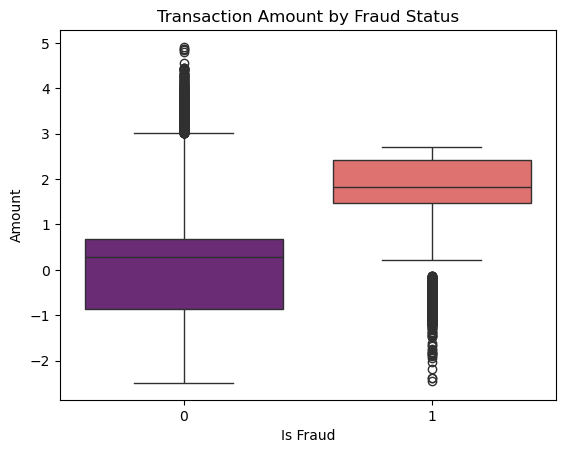

In [44]:
# plot (normalised) transaction amount by fraud status

sns.boxplot(data=fraud_train, x='is_fraud', y='amt_norm', palette='magma')
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.show()

# make graph

**Summary:**

- No. of nodes: 1676; No. of edges: 1296675
- No. of customers: 983; No. of merchants: 693
- Graph is bipartite
- There exists a central cluster of customer and merchant nodes, and several customer nodes far from this cluster. 
    - When only non-fraudulent transactions are drawn, the customer nodes outside the cluster are not connected to the cluster.
    - Customers involved in fraudulent transactions can be inside the cluster.

## create graph

In [45]:
print(fraud_train.columns)
print(fraud_test.columns)
print("No. of columns in fraud_train:", len(fraud_train.columns))
print("No. of columns in fraud_test:", len(fraud_test.columns))

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'count_last24h',
       'count_last7days', 'count_last30days', 'past_count_with_merchant',
       'gender_binary', 'distance', 'cc_num_degree_count',
       'merchant_degree_count', 'trans_date', 'age', 'week', 'day_of_week',
       'trans_hour', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'job_category', 'lat_norm', 'long_norm', 'merch_lat_norm',
       'merch_long_norm', 'distance_norm', 'age_norm', 'count_last24h_norm',
       'count_last7days_norm', 'count_last30days_norm', 'log_amt', 'amt_norm',
       'customer_degree_norm', 'merchant_degree_norm'],
      dtype='object')
Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gen

In [46]:
# Create a new graph
G = nx.MultiGraph()

# To one-hot encode: job_category, category, day_of_week, trans_hour done in iteration
# Initialize label encoders
job_category_encoder = LabelEncoder()
category_encoder = LabelEncoder()

# Obtain unique values
unique_job_categories = fraud_train['job_category'].unique()
unique_categories = fraud_train['category'].unique()

# Fit the encoders
job_category_encoder.fit(unique_job_categories)
category_encoder.fit(unique_categories)

# Iterate through the fraud_train dataframe to add nodes and edges
for index, row in fraud_train.iterrows():
    customer_node = row['cc_num']
    merchant_node = row['merchant']
    transaction_id = row['trans_num']
    
    # Add customer node if it doesn't exist
    if not G.has_node(customer_node):
        # Node type (1 for Customer, 0 for Merchant)
        node_type = 1.0

        # Convert gender to binary (assume 1 for 'M' and 0 for 'F')
        gender_binary = 1.0 if row['gender'] == 'M' else 0.0

        age = row['age_norm']

        # One-hot encode the job_category
        job_category_encoded = job_category_encoder.transform([row['job_category']])[0]
        job_category_vector = np.zeros(len(job_category_encoder.classes_))  # Create vector for 13 categories
        job_category_vector[job_category_encoded] = 1
        job_category_vector = job_category_vector.astype(float)

        # Zero vector for merchant category
        zero_vector = np.zeros(len(category_encoder.classes_))
    
        feature_vector = np.concatenate([ 
            [node_type, gender_binary, age], 
            job_category_vector, zero_vector,
            [row['lat_norm'], row['long_norm']]
        ])

        G.add_node(customer_node, type='customer', gender=gender_binary, age=age,
                    category=row['job_category'],
                    lat=row['lat_norm'], long=row['long_norm'], 
                    features=feature_vector)
    
    # Add merchant node if it doesn't exist
    if not G.has_node(merchant_node):
        # Node type (1 for Customer, 0 for Merchant)
        node_type = 0.0
        gender_binary = 0.0
        age = 0.0

        # One-hot encode the category
        category_encoded = category_encoder.transform([row['category']])[0]
        category_vector = np.zeros(len(category_encoder.classes_))  # Create vector for 14 categories
        category_vector[category_encoded] = 1
        category_vector = category_vector.astype(float)

        # Zero vector for job category
        zero_vector = np.zeros(len(job_category_encoder.classes_))

        feature_vector = np.concatenate([
            [node_type, gender_binary, age],
            zero_vector, category_vector, 
            [row['merch_lat_norm'], row['merch_long_norm']]
        ])
        G.add_node(merchant_node, type='merchant', gender=gender_binary, age=age,
                    category=row['category'],
                    lat=row['merch_lat_norm'], long=row['merch_long_norm'], 
                    features=feature_vector)
    
    # One-hot encode the day of week
    day_of_week_vector = np.zeros(7)
    day_of_week_vector[row['day_of_week'] - 1] = 1.0

    # One-hot encode the transaction hour (0, 1, ..., 22, 23)
    trans_hour_vector = np.zeros(24)
    trans_hour_vector[row['trans_hour']] = 1.0

    feature_vector = np.concatenate([
        [row['amt_norm']], day_of_week_vector, trans_hour_vector])

    # Add an edge between the customer and merchant with the transaction id
    G.add_edge(customer_node, merchant_node, trans_num=transaction_id, amt=row['amt_norm'], 
                trans_date_trans_time=row['trans_date_trans_time'], is_fraud=row['is_fraud'],
                distance = row['distance_norm'], features=feature_vector)

# Print the number of nodes and edges
print("training dataset")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("No. of customers:", len(nx.bipartite.sets(G)[0]))
print("No. of merchants:", len(nx.bipartite.sets(G)[1]))

training dataset
Number of nodes: 1676
Number of edges: 1296675
No. of customers: 983
No. of merchants: 693


In [47]:
# Create a new graph for test data
G_test = nx.MultiGraph()

# Iterate through the fraud_test dataframe to add nodes and edges
for index, row in fraud_test.iterrows():
    customer_node = row['cc_num']
    merchant_node = row['merchant']
    transaction_id = row['trans_num']
    
    # Add customer node if it doesn't exist
    if not G_test.has_node(customer_node):
        # Node type (1 for Customer, 0 for Merchant)
        node_type = 1.0

        # Convert gender to binary (assume 1 for 'M' and 0 for 'F')
        gender_binary = 1.0 if row['gender'] == 'M' else 0.0

        # Calculate age from dob
        dob = datetime.strptime(row['dob'], '%Y-%m-%d')  # dob is in 'YYYY-MM-DD' format
        trans_date = row['trans_date'] #datetime.strptime(row['trans_date_trans_time'], '%Y-%m-%d %H:%M:%S')
        age = float(trans_date.year - dob.year)

        # One-hot encode the job_category
        job_category_encoded = job_category_encoder.transform([row['job_category']])[0]
        job_category_vector = np.zeros(len(job_category_encoder.classes_))  # Create vector for 13 categories
        job_category_vector[job_category_encoded] = 1
        job_category_vector = job_category_vector.astype(float)

        # Zero vector for merchant category
        zero_vector = np.zeros(len(category_encoder.classes_))
    
        feature_vector = np.concatenate([ 
            [node_type, gender_binary, age], 
            job_category_vector, zero_vector,
            [row['lat_norm'], row['long_norm']]
        ])

        G_test.add_node(customer_node, type='customer', gender=gender_binary, age=age,
                    category=row['job_category'],
                    lat=row['lat_norm'], long=row['long_norm'], 
                    features=feature_vector)
    
    # Add merchant node if it doesn't exist
    if not G_test.has_node(merchant_node):
        # Node type (1 for Customer, 0 for Merchant)
        node_type = 0.0
        gender_binary = 0.0
        age = 0.0

        # One-hot encode the category
        category_encoded = category_encoder.transform([row['category']])[0]
        category_vector = np.zeros(len(category_encoder.classes_))  # Create vector for 14 categories
        category_vector[category_encoded] = 1
        category_vector = category_vector.astype(float)

        # Zero vector for job category
        zero_vector = np.zeros(len(job_category_encoder.classes_))

        feature_vector = np.concatenate([
            [node_type, gender_binary, age],
            zero_vector, category_vector, 
            [row['merch_lat_norm'], row['merch_long_norm']]
        ])
        G_test.add_node(merchant_node, type='merchant', gender=gender_binary, age=age,
                    category=row['category'],
                    lat=row['merch_lat_norm'], long=row['merch_long_norm'], 
                    features=feature_vector)
    
    # One-hot encode the day of week
    day_of_week_vector = np.zeros(7)
    day_of_week_vector[row['day_of_week'] - 1] = 1.0

    # One-hot encode the transaction hour
    trans_hour_vector = np.zeros(24)
    trans_hour_vector[row['trans_hour']] = 1.0

    feature_vector = np.concatenate([
        [row['amt_norm']], day_of_week_vector, trans_hour_vector])

    # Add an edge between the customer and merchant with the transaction id
    G_test.add_edge(customer_node, merchant_node, trans_num=transaction_id, amt=row['amt_norm'], 
                trans_date_trans_time=row['trans_date_trans_time'], is_fraud=row['is_fraud'],
                distance = row['distance_norm'], features=feature_vector)

# Print the number of nodes and edges
print("test dataset")
print(f"Number of nodes: {G_test.number_of_nodes()}")
print(f"Number of edges: {G_test.number_of_edges()}")
print("No. of customers:", len(nx.bipartite.sets(G_test)[0]))
print("No. of merchants:", len(nx.bipartite.sets(G_test)[1]))

test dataset
Number of nodes: 1617
Number of edges: 555719
No. of customers: 924
No. of merchants: 693


In [48]:
def get_feature_vector(graph, node):
    if graph.has_node(node):
        return graph.nodes[node]['features']
    else:
        return None

# Example usage
node_id = 2703186189652095  # Replace with the node ID you want to get the feature vector for
feature_vector = get_feature_vector(G, node_id)
print(f"Feature vector for customer node {node_id}: \n{feature_vector}")
print(F"Length of feature vector: {len(feature_vector)}")

# Example usage
node_id = 'fraud_Rippin, Kub and Mann'  # Replace with the node ID you want to get the feature vector for
feature_vector = get_feature_vector(G, node_id)
print(f"Feature vector for merchant node {node_id}: \n{feature_vector}")
print(F"Length of feature vector: {len(feature_vector)}")

Feature vector for customer node 2703186189652095: 
[ 1.          0.         -0.86462869  0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.4844197   0.65761936]
Length of feature vector: 32
Feature vector for merchant node fraud_Rippin, Kub and Mann: 
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
 -0.49435414  0.59386363]
Length of feature vector: 32


In [49]:
for u, v, data in G.edges(data=True):
    print("Feature vector of edge:\n", data['features'])
    print("Length of feature vector:", len(data['features']))
    break

Feature vector of edge:
 [-1.33593671  0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Length of feature vector: 32


## visualise training and test graph

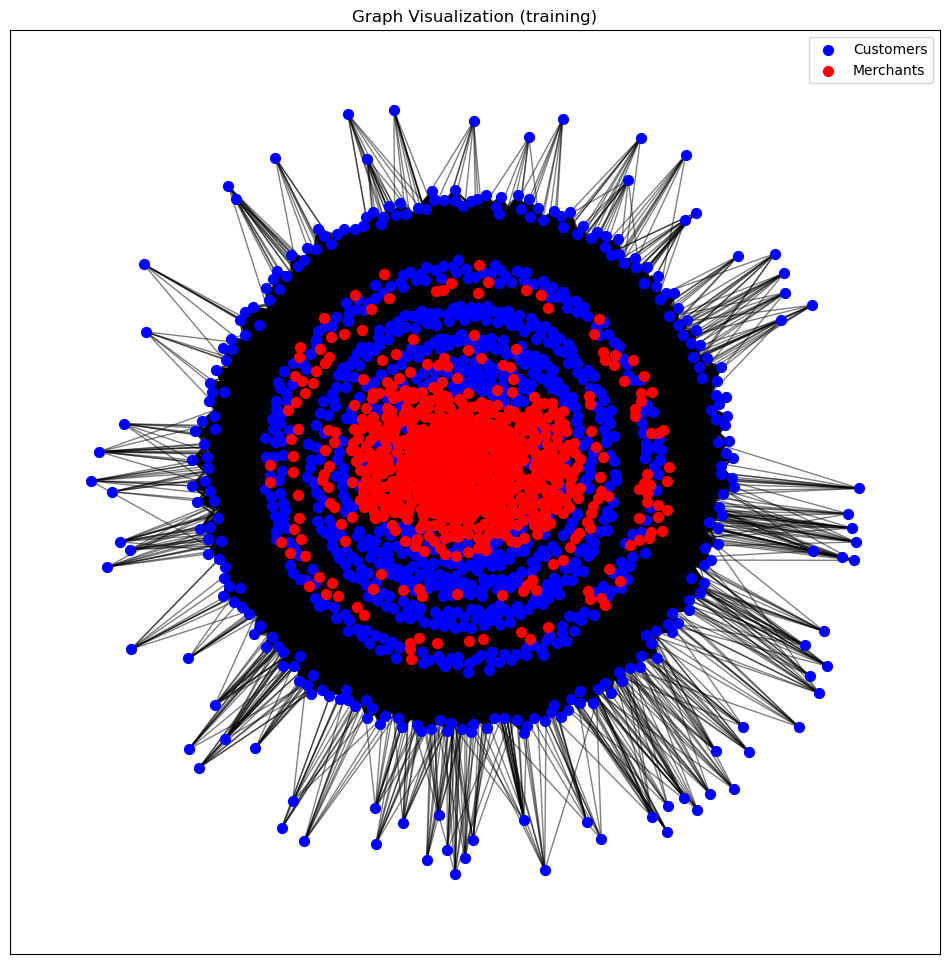

In [79]:
# Draw the graph with different colors for customer and merchant nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=1.5)

# Draw customer nodes
customer_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'customer']
nx.draw_networkx_nodes(G, pos, nodelist=customer_nodes, node_color='blue', node_size=50, label='Customers')

# Draw merchant nodes
merchant_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'merchant']
nx.draw_networkx_nodes(G, pos, nodelist=merchant_nodes, node_color='red', node_size=50, label='Merchants')

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, labels={node: '' for node in G.nodes()})

plt.title("Graph Visualization (training)")
plt.legend()
plt.show()

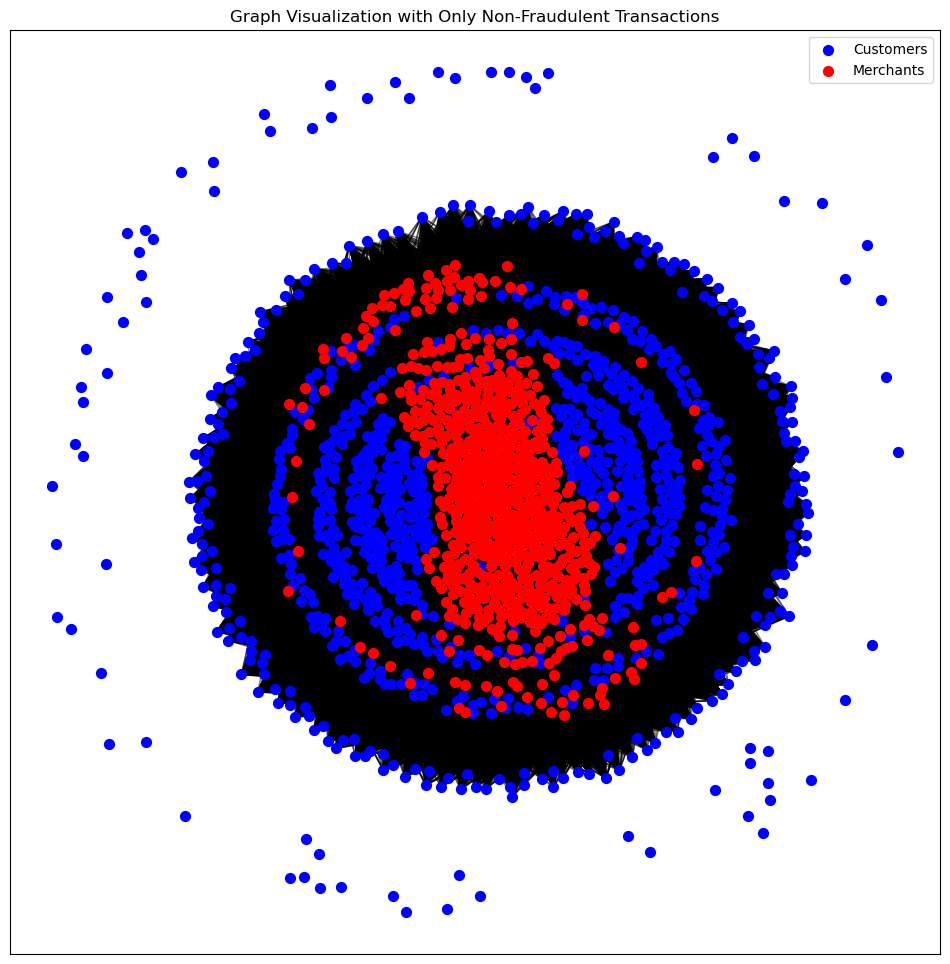

In [26]:
# Draw only non-fraudulent transactions

# Draw the graph with different colors for customer and merchant nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=1.5)

# Draw customer nodes
customer_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'customer']
nx.draw_networkx_nodes(G, pos, nodelist=customer_nodes, node_color='blue', node_size=50, label='Customers')

# Draw merchant nodes
merchant_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'merchant']
nx.draw_networkx_nodes(G, pos, nodelist=merchant_nodes, node_color='red', node_size=50, label='Merchants')

# Draw edges
edges = G.edges(data=True)
fraud_edges = [(u, v) for u, v, d in edges if d['is_fraud'] == 1]
non_fraud_edges = [(u, v) for u, v, d in edges if d['is_fraud'] == 0]

nx.draw_networkx_edges(G, pos, edgelist=non_fraud_edges, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, labels={node: '' for node in G.nodes()})

plt.title("Graph Visualization with Only Non-Fraudulent Transactions (training)")
plt.legend()
plt.show()

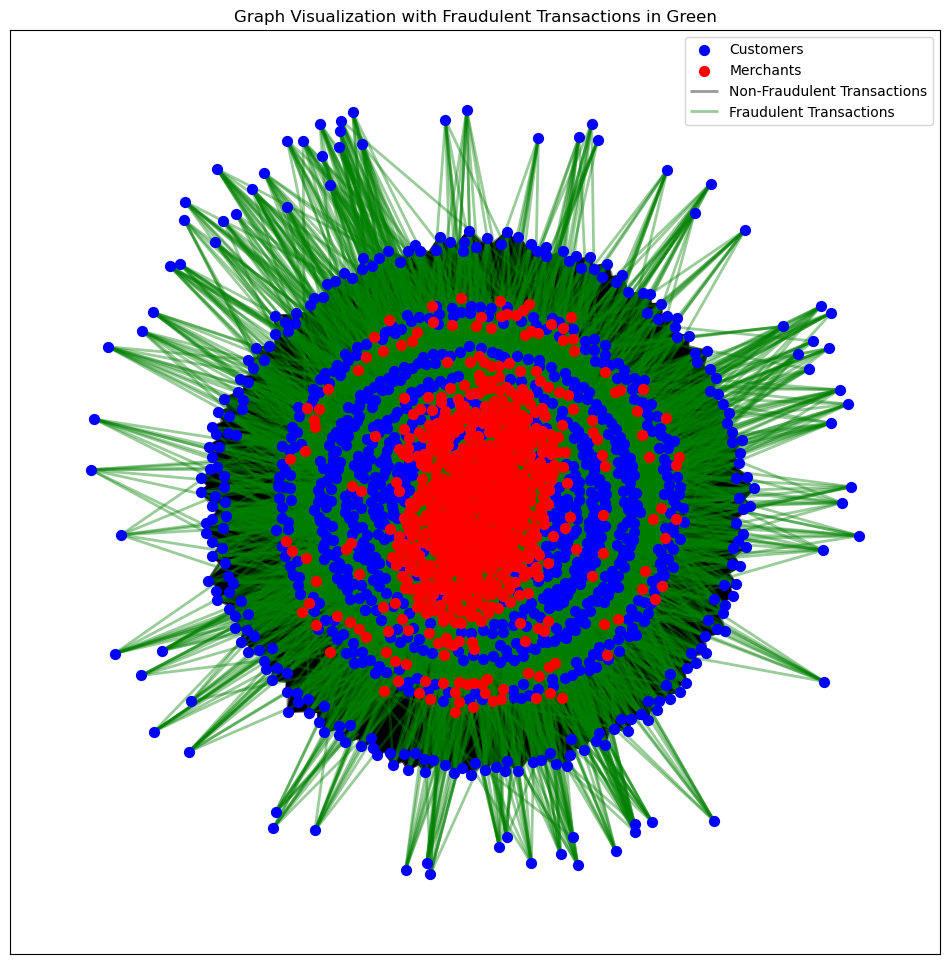

In [28]:
# Make fraudulent transactions a different colour

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=1.5)  # positions for all nodes

# Draw customer nodes
customer_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'customer']
nx.draw_networkx_nodes(G, pos, nodelist=customer_nodes, node_color='blue', node_size=50, label='Customers')

# Draw merchant nodes
merchant_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'merchant']
nx.draw_networkx_nodes(G, pos, nodelist=merchant_nodes, node_color='red', node_size=50, label='Merchants')

# Draw edges
edges = G.edges(data=True)
fraud_edges = [(u, v) for u, v, d in edges if d['is_fraud'] == 1]
non_fraud_edges = [(u, v) for u, v, d in edges if d['is_fraud'] == 0]

nx.draw_networkx_edges(G, pos, edgelist=non_fraud_edges, edge_color='black', alpha=0.4, width=2, label='Non-Fraudulent Transactions')
nx.draw_networkx_edges(G, pos, edgelist=fraud_edges, edge_color='green', alpha=0.4, width=2, label='Fraudulent Transactions')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, labels={node: '' for node in G.nodes()})

plt.title("Graph Visualization with Fraudulent Transactions in Green (training)")
plt.legend()
plt.show()

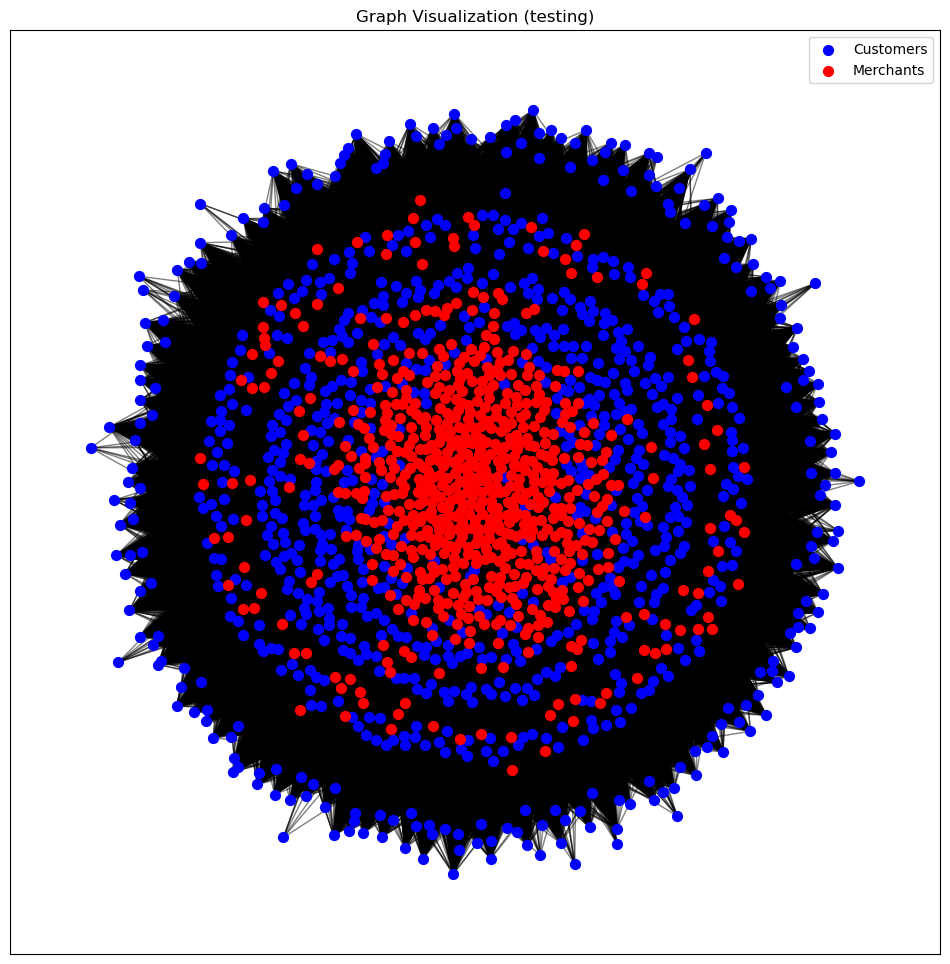

In [149]:
# Draw the graph with different colors for customer and merchant nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_test, k=1.5)

# Draw customer nodes
customer_nodes = [node for node, data in G_test.nodes(data=True) if data['type'] == 'customer']
nx.draw_networkx_nodes(G_test, pos, nodelist=customer_nodes, node_color='blue', node_size=50, label='Customers')

# Draw merchant nodes
merchant_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'merchant']
nx.draw_networkx_nodes(G_test, pos, nodelist=merchant_nodes, node_color='red', node_size=50, label='Merchants')

# Draw edges
nx.draw_networkx_edges(G_test, pos, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G_test, pos, font_size=8, labels={node: '' for node in G_test.nodes()})

plt.title("Graph Visualization (testing)")
plt.legend()
plt.show()

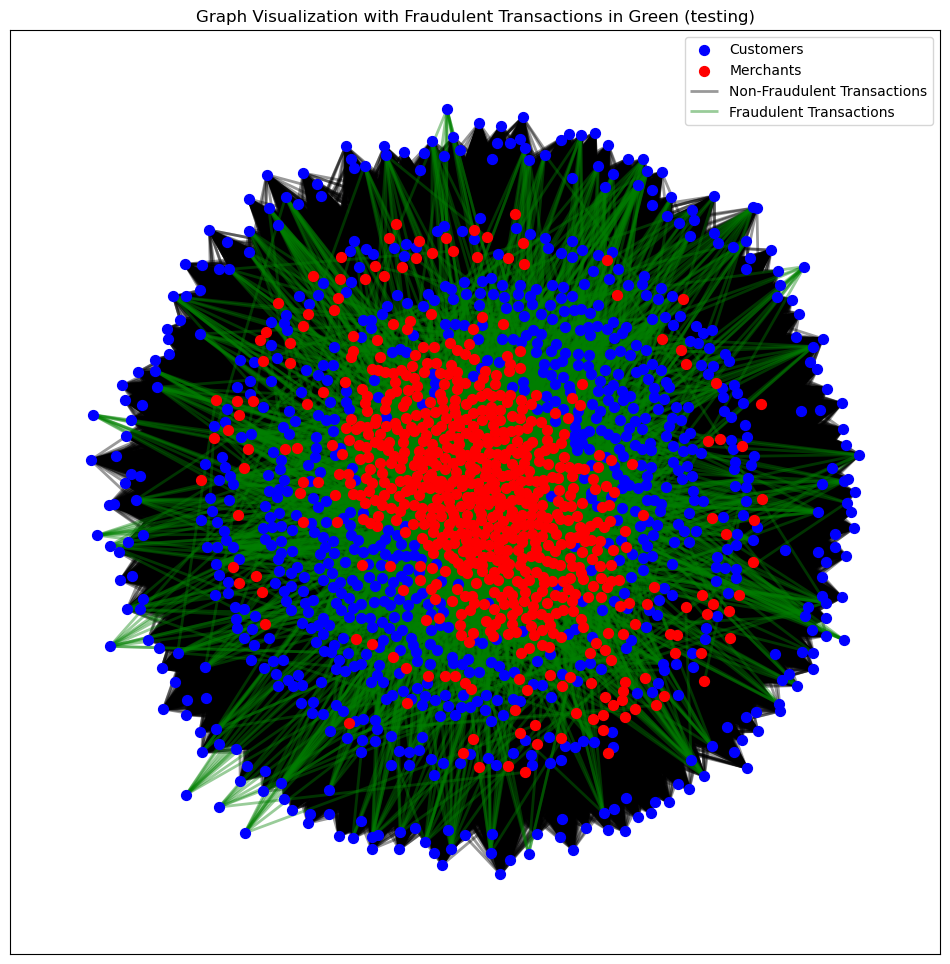

In [151]:
# Make fraudulent transactions a different colour

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_test, k=1.5)  # positions for all nodes

# Draw customer nodes
customer_nodes = [node for node, data in G_test.nodes(data=True) if data['type'] == 'customer']
nx.draw_networkx_nodes(G_test, pos, nodelist=customer_nodes, node_color='blue', node_size=50, label='Customers')

# Draw merchant nodes
merchant_nodes = [node for node, data in G_test.nodes(data=True) if data['type'] == 'merchant']
nx.draw_networkx_nodes(G_test, pos, nodelist=merchant_nodes, node_color='red', node_size=50, label='Merchants')

# Draw edges
edges = G_test.edges(data=True)
fraud_edges = [(u, v) for u, v, d in edges if d['is_fraud'] == 1]
non_fraud_edges = [(u, v) for u, v, d in edges if d['is_fraud'] == 0]

nx.draw_networkx_edges(G_test, pos, edgelist=non_fraud_edges, edge_color='black', alpha=0.4, width=2, label='Non-Fraudulent Transactions')
nx.draw_networkx_edges(G_test, pos, edgelist=fraud_edges, edge_color='green', alpha=0.4, width=2, label='Fraudulent Transactions')

# Draw labels
nx.draw_networkx_labels(G_test, pos, font_size=8, labels={node: '' for node in G_test.nodes()})

plt.title("Graph Visualization with Fraudulent Transactions in Green (testing)")
plt.legend()
plt.show()

## create random bipartite graph for visualisation

Bipartite graph with 500 customers, 300 merchants and edge probability of 0.5


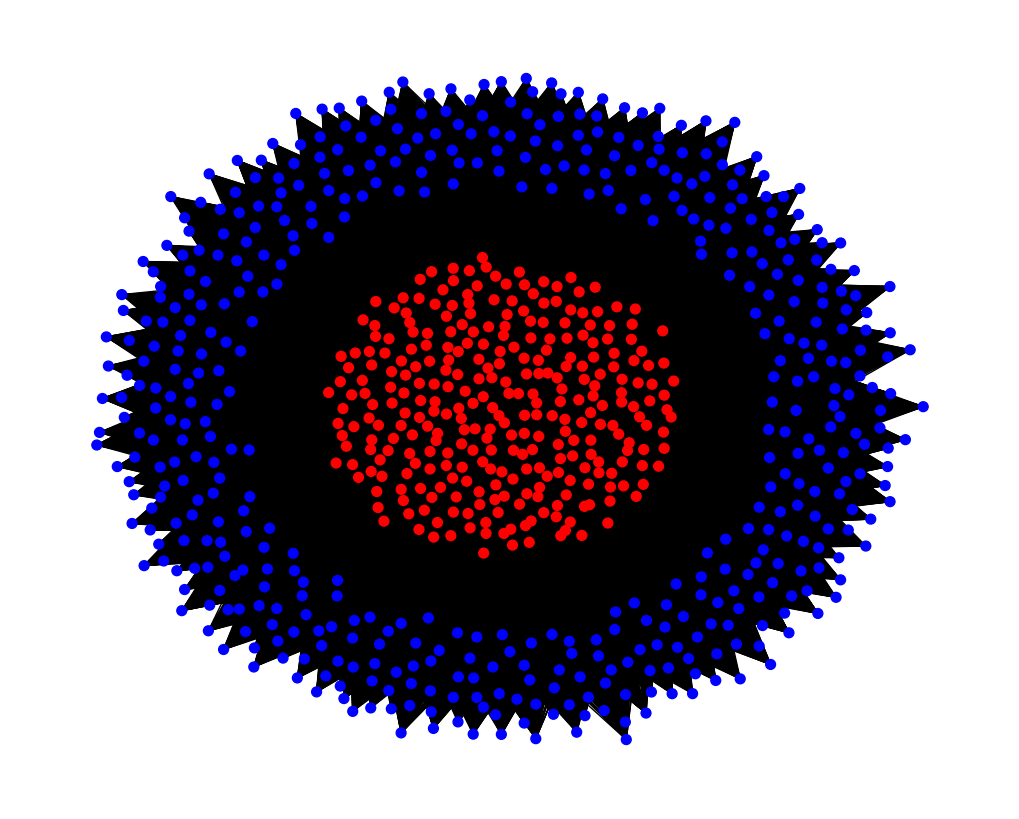

In [274]:
def generate_bipartite_graph(num_customers=500, num_merchants=300, edge_probability=0.5):
    B = nx.Graph()
    
    # Create nodes
    customers = [f'C{i}' for i in range(num_customers)]
    merchants = [f'M{i}' for i in range(num_merchants)]
    
    # Ensure lists are flat and contain strings
    assert all(isinstance(c, str) for c in customers), "Customers list contains non-string values"
    assert all(isinstance(m, str) for m in merchants), "Merchants list contains non-string values"
    
    B.add_nodes_from(customers, bipartite=0)
    B.add_nodes_from(merchants, bipartite=1)
    
    # Create random edges between customers and merchants
    for c in customers:
        for m in merchants:
            if random.random() < edge_probability:
                B.add_edge(c, m)
    
    return B, customers, merchants

def draw_bipartite_graph(B, customers, merchants):
    plt.figure(figsize=(10, 8))
    node_colors = ['blue' if node in customers else 'red' for node in B.nodes()]
    pos = nx.spring_layout(B, k=0.5)
    nx.draw(B, pos, with_labels=False, node_size=50, node_color=node_colors)
    plt.show()


# Generate and draw graph
B, customers, merchants = generate_bipartite_graph()
print(f"Bipartite graph with {len(customers)} customers, {len(merchants)} merchants and edge probability of 0.5")
draw_bipartite_graph(B, customers, merchants)

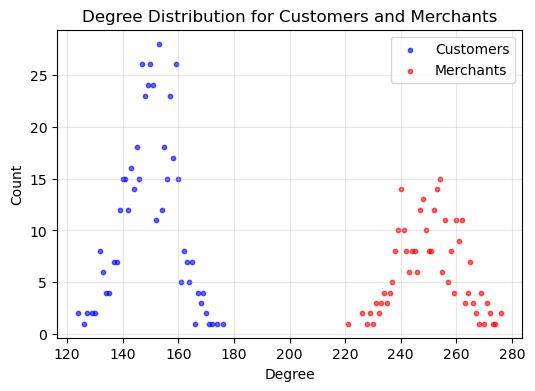

In [275]:
# Calculate degree counts for customers and merchants
customer_degree_counts = {}
merchant_degree_counts = {}

for customer in customers:
    degree = B.degree(customer)
    customer_degree_counts[degree] = customer_degree_counts.get(degree, 0) + 1

for merchant in merchants:
    degree = B.degree(merchant)
    merchant_degree_counts[degree] = merchant_degree_counts.get(degree, 0) + 1

# Plot scatter plot for customers
plt.figure(figsize=(6, 4))
plt.scatter(customer_degree_counts.keys(), customer_degree_counts.values(), s=10, c='blue', label='Customers', alpha=0.6)

# Plot scatter plot for merchants
plt.scatter(merchant_degree_counts.keys(), merchant_degree_counts.values(), s=10, c='red', label='Merchants', alpha=0.6)

# Add labels and title
plt.title('Degree Distribution for Customers and Merchants')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Bipartite graph with 500 customers, 300 merchants and 3 different probabilities for customers


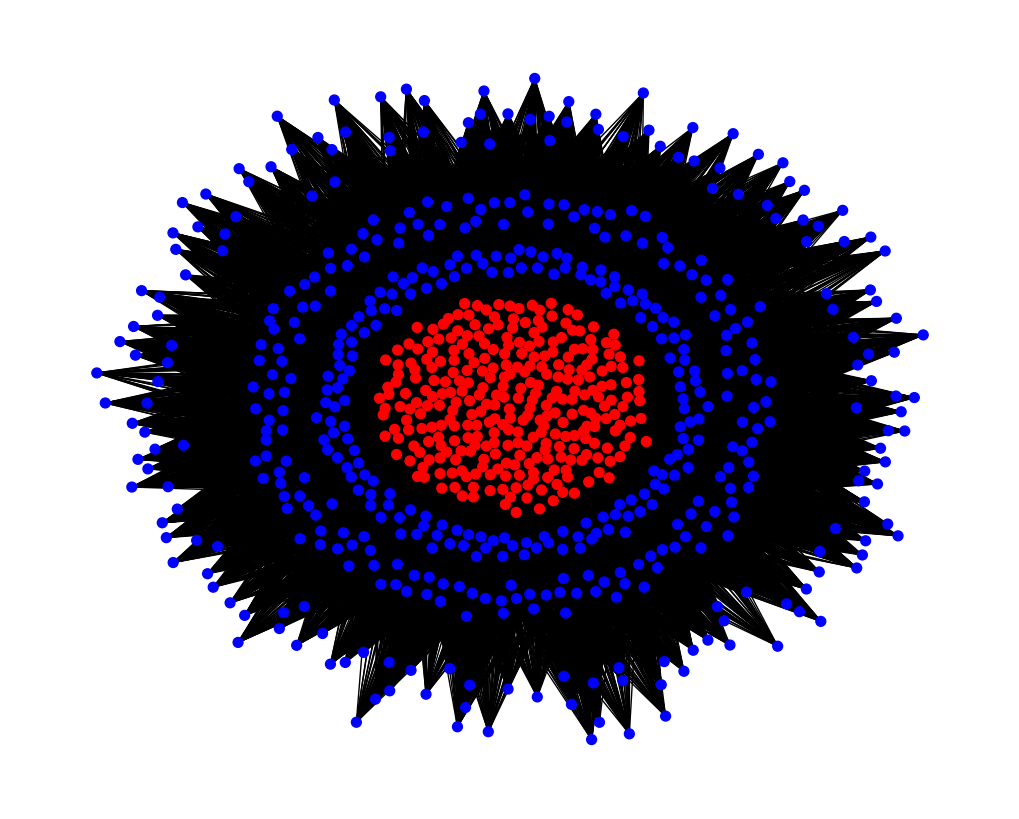

In [271]:
def generate_bipartite_graph(num_customers=500, num_merchants=300):
    B = nx.Graph()
    
    # Create nodes
    customers = [f'C{i}' for i in range(num_customers)]
    merchants = [f'M{i}' for i in range(num_merchants)]
    B.add_nodes_from(customers, bipartite=0)
    B.add_nodes_from(merchants, bipartite=1)
    
    # Assign different spending habits to customers
    spending_habits = {c: random.choice([0.2, 0.5, 0.8]) for c in customers}  # Probability of making a purchase
    
    # Create random edges based on spending habits
    for c in customers:
        for m in merchants:
            if random.random() < spending_habits[c]:
                B.add_edge(c, m)
    
    return B, customers, merchants

B, customers, merchants = generate_bipartite_graph()
print(f"Bipartite graph with {len(customers)} customers, {len(merchants)} merchants and 3 different probabilities for customers")
draw_bipartite_graph(B, customers, merchants)


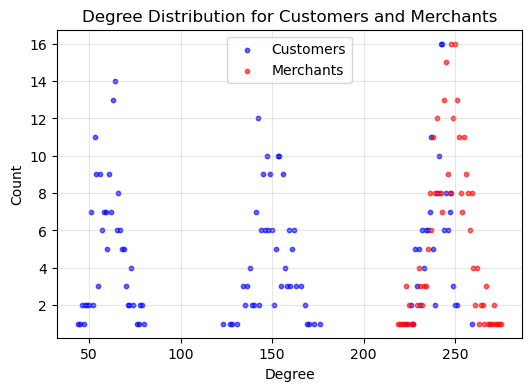

In [273]:
# Calculate degree counts for customers and merchants
customer_degree_counts = {}
merchant_degree_counts = {}

for customer in customers:
    degree = B.degree(customer)
    customer_degree_counts[degree] = customer_degree_counts.get(degree, 0) + 1

for merchant in merchants:
    degree = B.degree(merchant)
    merchant_degree_counts[degree] = merchant_degree_counts.get(degree, 0) + 1

# Plot scatter plot for customers
plt.figure(figsize=(6, 4))
plt.scatter(customer_degree_counts.keys(), customer_degree_counts.values(), s=10, c='blue', label='Customers', alpha=0.6)

# Plot scatter plot for merchants
plt.scatter(merchant_degree_counts.keys(), merchant_degree_counts.values(), s=10, c='red', label='Merchants', alpha=0.6)

# Add labels and title
plt.title('Degree Distribution for Customers and Merchants')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Bipartite graph with 500 customers, 300 merchants and 3 probabilities for customers, 2 probabilities for merchants


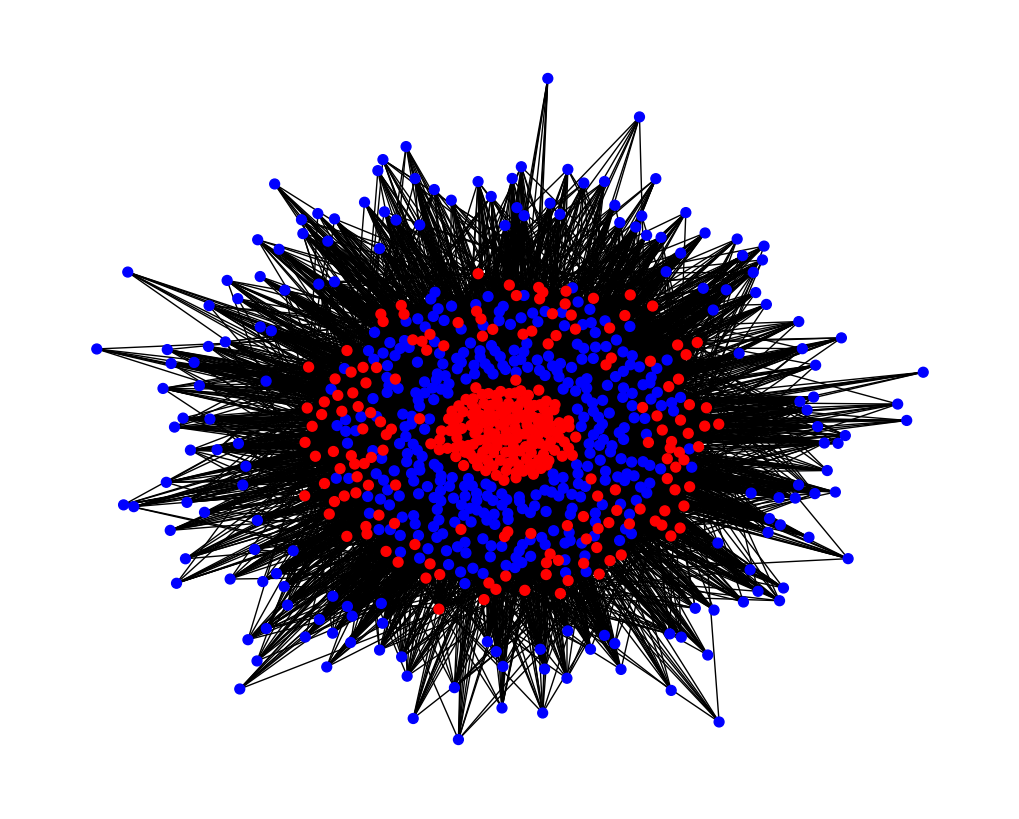

In [276]:
def generate_bipartite_graph(num_customers=500, num_merchants=300):
    B = nx.Graph()
    
    # Create nodes
    customers = [f'C{i}' for i in range(num_customers)]
    merchants = [f'M{i}' for i in range(num_merchants)]
    B.add_nodes_from(customers, bipartite=0)
    B.add_nodes_from(merchants, bipartite=1)
    
    # Assign different spending habits to customers
    spending_habits = {c: random.choice([0.1, 0.4, 0.7]) for c in customers}  # Probability of making a purchase
    
    # Assign popularity scores to merchants
    popularity_scores = {m: random.choice([0.3, 0.9]) for m in merchants}  # Probability of attracting a customer
    
    # Create random edges based on spending habits and popularity scores
    for c in customers:
        for m in merchants:
            if random.random() < (spending_habits[c] * popularity_scores[m]):
                B.add_edge(c, m)
    
    return B, customers, merchants

# Generate and draw graph
B, customers, merchants = generate_bipartite_graph()
print(f"Bipartite graph with {len(customers)} customers, {len(merchants)} merchants and 3 probabilities for customers, 2 probabilities for merchants")
draw_bipartite_graph(B, customers, merchants)

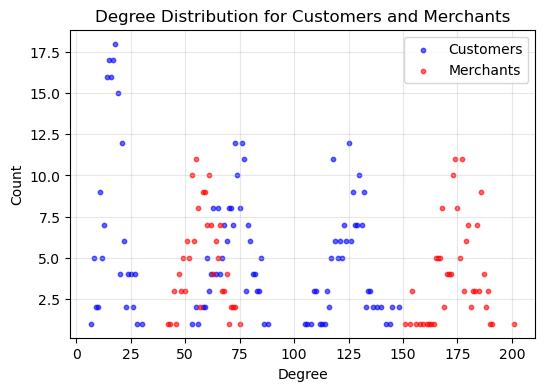

In [278]:
# Calculate degree counts for customers and merchants
customer_degree_counts = {}
merchant_degree_counts = {}

for customer in customers:
    degree = B.degree(customer)
    customer_degree_counts[degree] = customer_degree_counts.get(degree, 0) + 1

for merchant in merchants:
    degree = B.degree(merchant)
    merchant_degree_counts[degree] = merchant_degree_counts.get(degree, 0) + 1

# Plot scatter plot for customers
plt.figure(figsize=(6, 4))
plt.scatter(customer_degree_counts.keys(), customer_degree_counts.values(), s=10, c='blue', label='Customers', alpha=0.6)

# Plot scatter plot for merchants
plt.scatter(merchant_degree_counts.keys(), merchant_degree_counts.values(), s=10, c='red', label='Merchants', alpha=0.6)

# Add labels and title
plt.title('Degree Distribution for Customers and Merchants')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## extract graph info

In [ ]:
## Define edge_index, edge_attr, node_mapping, node_reverse_mapping, customer_mask, merchant_mask, customer_lat_long, merchant_lat_long, x

# Extract edge index and edge attributes from the graph G
edge_index = []
edge_attr = []

# Create a mapping from node labels to integers and vice versa
node_mapping = {node: i for i, node in enumerate(G.nodes())} # {name of node: index}
node_reverse_mapping = {i: node for i, node in enumerate(G.nodes())} # {index: name of node}

# Iterate through the edges and add to edge_index and edge_attr
for u, v, data in G.edges(data=True):
    edge_index.append([node_mapping[u], node_mapping[v]])
    edge_attr.append(data['features'])

# Convert edge_index to a PyTorch tensor and ensure it's transposed
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Convert edge_attr to a tensor before using torch.stack
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

print("edge_index type:",type(edge_index))
print("edge_attr type:",type(edge_attr))
print("Edge Index shape:", edge_index.shape) # Expected: torch.Size([2, 1296675])
print("Edge Attributes shape:", edge_attr.shape) # Expected: torch.Size([1296675, 32])
print(edge_index)
print(edge_attr)

# Extract node features
x=[]
x = np.array([np.array(G.nodes[node]['features'], dtype=np.float32) for node in G.nodes])

# Convert to PyTorch tensor
x = torch.tensor(x, dtype=torch.float)

print("Node Feature Matrix Shape:", x.shape)  # Should be (1676, 32)

# predict amt

In [53]:
# Merge the dataframes on 'trans_num'
fraud_train = fraud_train.merge(customer_closeness_df[['trans_num', 'closeness_centrality']], on='trans_num', how='left')

print(fraud_train.shape)

(1296675, 56)


In [54]:
print(fraud_train.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'count_last24h',
       'count_last7days', 'count_last30days', 'past_count_with_merchant',
       'gender_binary', 'distance', 'cc_num_degree_count',
       'merchant_degree_count', 'trans_date', 'age', 'week', 'day_of_week',
       'trans_hour', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'job_category', 'lat_norm', 'long_norm', 'merch_lat_norm',
       'merch_long_norm', 'distance_norm', 'age_norm', 'count_last24h_norm',
       'count_last7days_norm', 'count_last30days_norm', 'log_amt', 'amt_norm',
       'customer_degree_norm', 'merchant_degree_norm', 'closeness_centrality'],
      dtype='object')


## linear regression

In [214]:
# predict: amt_norm
# keep only:
columns_to_use = ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

X_train, y_train = [], []
X_train = fraud_train[columns_to_use].values.astype(float)
y_train = fraud_train['amt_norm'].values

X_train = np.array(X_train)
y_train = np.array(y_train)

In [215]:
# fit OLS model
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Adds a column of 1s for intercept
amt_model_1 = sm.OLS(y_train, X_train_with_intercept).fit()

# predict on training data
y_train_pred = amt_model_1.predict(X_train_with_intercept)

# Convert predictions and actual values back to original scale (assuming train_stats for normalization)
mean = train_stats['amt']['mean']
std = train_stats['amt']['std']

# Reverse Z-score normalization for predictions and actual values
y_train_pred_original = np.exp(reverse_zscore(y_train_pred, mean, std))
y_train_original = np.exp(reverse_zscore(y_train, mean, std))

# Compute RMSE
print("Training RMSE (normalised):", mean_squared_error(y_train, y_train_pred, squared=False))
print("Training RMSE (original):", mean_squared_error(y_train_original, y_train_pred_original, squared=False))

print(amt_model_1.summary(xname=['Intercept'] + columns_to_use))

Training RMSE (normalised): 0.9631112208805731
Training RMSE (original): 161.88253481155152
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     7787.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:07:45   Log-Likelihood:            -1.7912e+06
No. Observations:             1296675   AIC:                         3.582e+06
Df Residuals:                 1296661   BIC:                         3.583e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


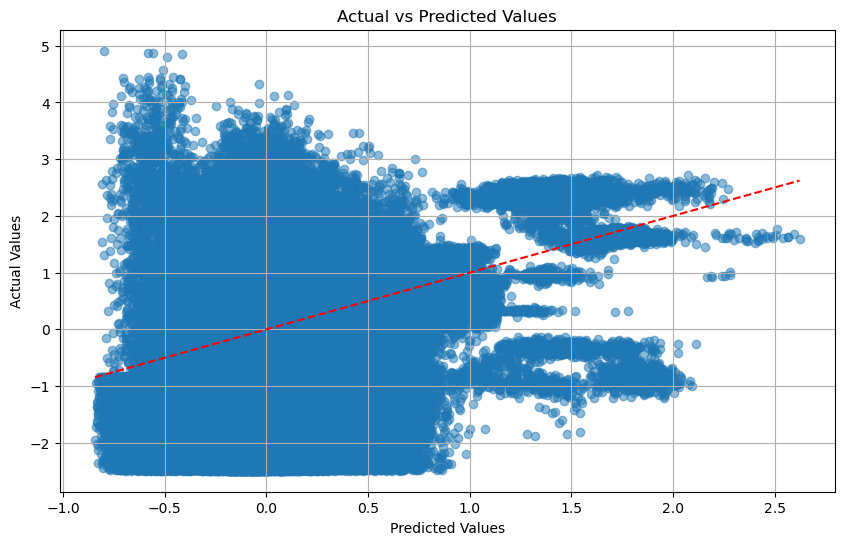

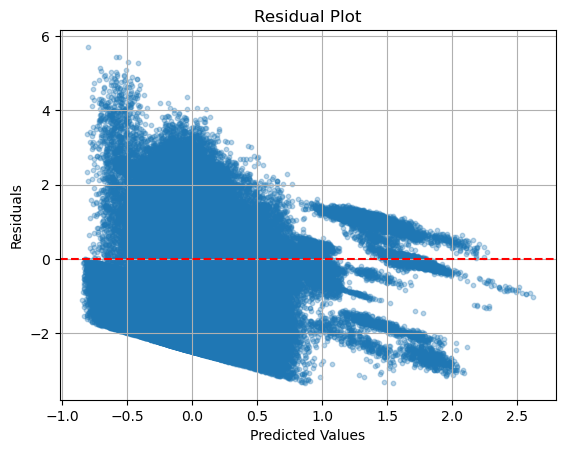

In [216]:
# Calculate residuals
residuals = y_train - y_train_pred

# Plot y_train vs y_train_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, y_train, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.plot([min(y_train_pred), max(y_train_pred)], [min(y_train_pred), max(y_train_pred)], color='red', linestyle='--')
plt.show()

plt.scatter(y_train_pred, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [217]:
# predict: amt_norm
# keep only:
columns_to_use = ['merchant_degree_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

X_train, y_train = [], []
X_train = fraud_train[columns_to_use].values.astype(float)
y_train = fraud_train['amt_norm'].values

X_train = np.array(X_train)
y_train = np.array(y_train)

In [218]:
# fit OLS model
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Adds a column of 1s for intercept
amt_model_2 = sm.OLS(y_train, X_train_with_intercept).fit()

# predict on training data
y_train_pred = amt_model_2.predict(X_train_with_intercept)

# Convert predictions and actual values back to original scale (assuming train_stats for normalization)
mean = train_stats['amt']['mean']
std = train_stats['amt']['std']

# Reverse Z-score normalization for predictions and actual values
y_train_pred_original = np.exp(reverse_zscore(y_train_pred, mean, std))
y_train_original = np.exp(reverse_zscore(y_train, mean, std))

# Compute RMSE
print("Training RMSE (normalised):", mean_squared_error(y_train, y_train_pred, squared=False))
print("Training RMSE (original):", mean_squared_error(y_train_original, y_train_pred_original, squared=False))

print(amt_model_2.summary(xname=['Intercept'] + columns_to_use))

Training RMSE (normalised): 0.9658646726386247
Training RMSE (original): 161.89000976834754
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     8479.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:08:47   Log-Likelihood:            -1.7949e+06
No. Observations:             1296675   AIC:                         3.590e+06
Df Residuals:                 1296663   BIC:                         3.590e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


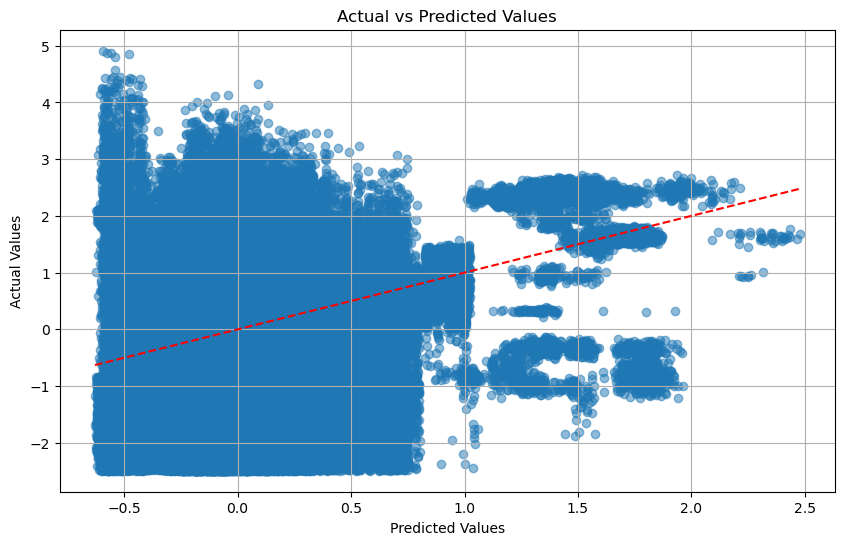

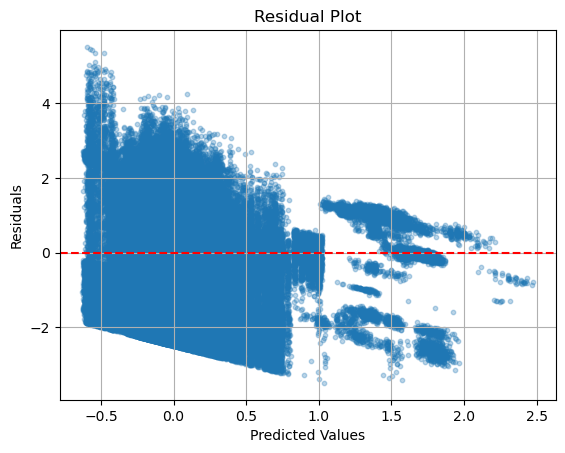

In [219]:
# Calculate residuals
residuals = y_train - y_train_pred

# Plot y_train vs y_train_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, y_train, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.plot([min(y_train_pred), max(y_train_pred)], [min(y_train_pred), max(y_train_pred)], color='red', linestyle='--')
plt.show()

plt.scatter(y_train_pred, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [220]:
fraud_train[["customer_degree_norm", "age_norm", "gender_binary"]].corr()

customer_degree_norm  age_norm  gender_binary
customer_degree_norm              1.000000 -0.349414      -0.215766
age_norm                         -0.349414  1.000000       0.004958
gender_binary                    -0.215766  0.004958       1.000000

could be non-linear relationship

transform variables, or interaction terms, or missing variables

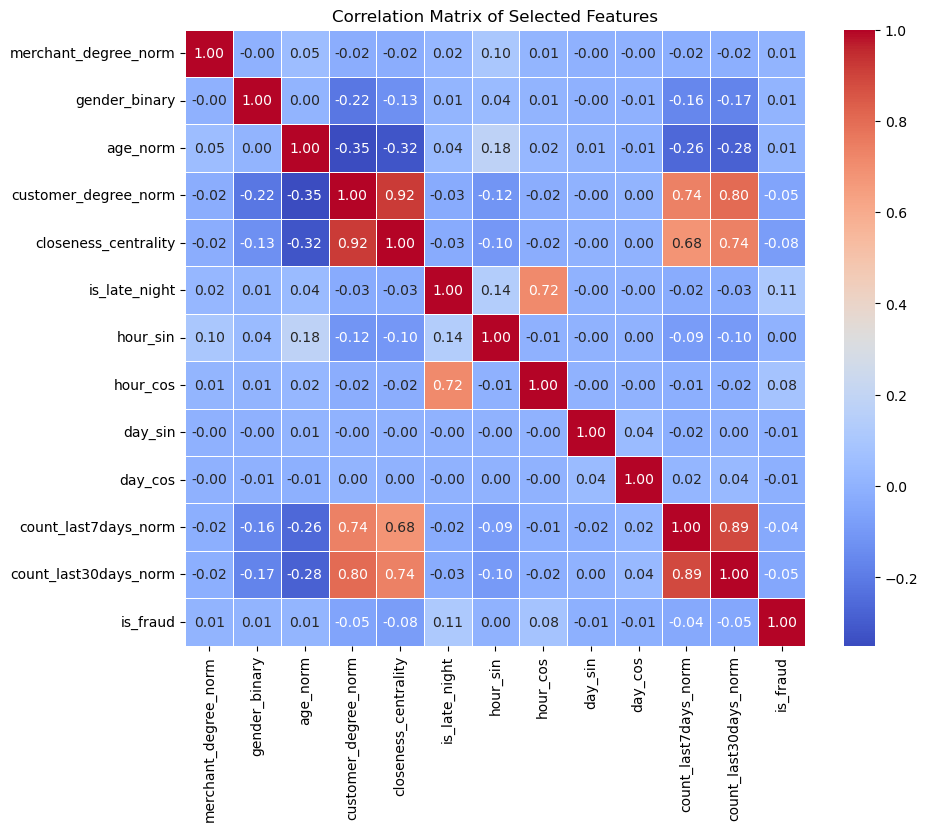

In [221]:
columns_to_use = columns_to_use = ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

plt.figure(figsize=(10, 8))
sns.heatmap(fraud_train[columns_to_use].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

In [222]:
# predict: amt_norm

category_encoder = OneHotEncoder(handle_unknown='ignore')
category_encoder.fit(fraud_train[['category']])
category_array = category_encoder.transform(fraud_train[['category']]).toarray()

columns_to_use = ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

X_train, y_train = [], []

# Extract feature matrix (excluding category first)
X_train = fraud_train[columns_to_use].values.astype(float)
y_train = fraud_train['amt_norm'].values

X_train = np.concatenate([X_train, category_array], axis=1)
X_train = X_train[:, :-1]

X_train = np.array(X_train)
y_train = np.array(y_train)

category_names = category_encoder.get_feature_names_out(['category'])
columns_to_use = columns_to_use + list(category_names)
columns_to_use = columns_to_use[:-1]

In [223]:
# fit OLS model
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Adds a column of 1s for intercept
amt_model_3 = sm.OLS(y_train, X_train_with_intercept).fit()

# predict on training data
y_train_pred = amt_model_3.predict(X_train_with_intercept)

# Convert predictions and actual values back to original scale (assuming train_stats for normalization)
mean = train_stats['amt']['mean']
std = train_stats['amt']['std']

# Reverse Z-score normalization for predictions and actual values
y_train_pred_original = np.exp(reverse_zscore(y_train_pred, mean, std))
y_train_original = np.exp(reverse_zscore(y_train, mean, std))

# Compute RMSE
print("Training RMSE (normalised):", mean_squared_error(y_train, y_train_pred, squared=False))
print("Training RMSE (original):", mean_squared_error(y_train_original, y_train_pred_original, squared=False))

print(amt_model_3.summary(xname=['Intercept'] + columns_to_use))

Training RMSE (normalised): 0.8860468134281969
Training RMSE (original): 164.15052097599676
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                 1.365e+04
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:09:45   Log-Likelihood:            -1.6830e+06
No. Observations:             1296675   AIC:                         3.366e+06
Df Residuals:                 1296648   BIC:                         3.366e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [224]:
# predict: amt_norm
# keep only:
# merchant_degree_norm, gender_binary, age_norm, customer_degree_norm, 
# closeness_centrality, is_late_night, count_last7days_norm, count_last30days_norm, is_fraud, category one hot

# Create a OneHotEncoder for the category
category_encoder = OneHotEncoder(handle_unknown='ignore')
category_encoder.fit(fraud_train[['category']])
category_array = category_encoder.transform(fraud_train[['category']]).toarray()

job_encoder = OneHotEncoder(handle_unknown='ignore')
job_encoder.fit(fraud_train[['job_category']])
job_array = job_encoder.transform(fraud_train[['job_category']]).toarray()

columns_to_use = ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

X_train, y_train = [], []

# Extract feature matrix (excluding category first)
X_train = fraud_train[columns_to_use].values.astype(float)
y_train = fraud_train['amt_norm'].values

X_train = np.concatenate([X_train, category_array], axis=1)
X_train = X_train[:, :-1]
X_train = np.concatenate([X_train, job_array], axis=1)
X_train = X_train[:, :-1]
X_train = np.array(X_train)
y_train = np.array(y_train)

category_names = category_encoder.get_feature_names_out(['category'])
columns_to_use = columns_to_use + list(category_names)
columns_to_use = columns_to_use[:-1]
job_names = job_encoder.get_feature_names_out(['job_category'])
columns_to_use = columns_to_use + list(job_names)
columns_to_use = columns_to_use[:-1]


In [225]:
# fit OLS model
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Adds a column of 1s for intercept
amt_model_4 = sm.OLS(y_train, X_train_with_intercept).fit()

# predict on training data
y_train_pred = amt_model_4.predict(X_train_with_intercept)

# Convert predictions and actual values back to original scale (assuming train_stats for normalization)
mean = train_stats['amt']['mean']
std = train_stats['amt']['std']

# Reverse Z-score normalization for predictions and actual values
y_train_pred_original = np.exp(reverse_zscore(y_train_pred, mean, std))
y_train_original = np.exp(reverse_zscore(y_train, mean, std))

# Compute RMSE
print("Training RMSE (normalised):", mean_squared_error(y_train, y_train_pred, squared=False))
print("Training RMSE (original):", mean_squared_error(y_train_original, y_train_pred_original, squared=False))

print(amt_model_4.summary(xname=['Intercept'] + columns_to_use))

Training RMSE (normalised): 0.8855839435213263
Training RMSE (original): 164.1615660228873
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     9387.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:09:59   Log-Likelihood:            -1.6823e+06
No. Observations:             1296675   AIC:                         3.365e+06
Df Residuals:                 1296636   BIC:                         3.365e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [226]:
# predict: amt_norm
# keep only:
columns_to_use = ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm']

X_train, y_train = [], []
X_train = fraud_train[columns_to_use].values.astype(float)
y_train = fraud_train['amt_norm'].values

X_train = np.array(X_train)
y_train = np.array(y_train)

In [227]:
# fit OLS model
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Adds a column of 1s for intercept
amt_model_5 = sm.OLS(y_train, X_train_with_intercept).fit()

# predict on training data
y_train_pred = amt_model_5.predict(X_train_with_intercept)

# Convert predictions and actual values back to original scale (assuming train_stats for normalization)
mean = train_stats['amt']['mean']
std = train_stats['amt']['std']

# Reverse Z-score normalization for predictions and actual values
y_train_pred_original = np.exp(reverse_zscore(y_train_pred, mean, std))
y_train_original = np.exp(reverse_zscore(y_train, mean, std))

# Compute RMSE
print("Training RMSE (normalised):", mean_squared_error(y_train, y_train_pred, squared=False))
print("Training RMSE (original):", mean_squared_error(y_train_original, y_train_pred_original, squared=False))

print(amt_model_5.summary(xname=['Intercept'] + columns_to_use))

Training RMSE (normalised): 0.9693297870428956
Training RMSE (original): 164.45653999011031
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6946.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:10:15   Log-Likelihood:            -1.7995e+06
No. Observations:             1296675   AIC:                         3.599e+06
Df Residuals:                 1296662   BIC:                         3.599e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [253]:
# predict: amt_norm
# keep only:
# merchant_degree_norm, gender_binary, age_norm, customer_degree_norm, 
# closeness_centrality, is_late_night, count_last7days_norm, count_last30days_norm, is_fraud, category one hot

# Create a OneHotEncoder for the category
category_encoder = OneHotEncoder(handle_unknown='ignore')
category_encoder.fit(fraud_train[['category']])
category_array = category_encoder.transform(fraud_train[['category']]).toarray()

job_encoder = OneHotEncoder(handle_unknown='ignore')
job_encoder.fit(fraud_train[['job_category']])
job_array = job_encoder.transform(fraud_train[['job_category']]).toarray()

columns_to_use = ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'past_count_with_merchant',
'is_fraud']

X_train, y_train = [], []

# Extract feature matrix (excluding category first)
X_train = fraud_train[columns_to_use].values.astype(float)
y_train = fraud_train['amt_norm'].values

X_train = np.concatenate([X_train, category_array], axis=1)
X_train = X_train[:, :-1]
X_train = np.concatenate([X_train, job_array], axis=1)
X_train = X_train[:, :-1]
X_train = np.array(X_train)
y_train = np.array(y_train)

category_names = category_encoder.get_feature_names_out(['category'])
columns_to_use = columns_to_use + list(category_names)
columns_to_use = columns_to_use[:-1]
job_names = job_encoder.get_feature_names_out(['job_category'])
columns_to_use = columns_to_use + list(job_names)
columns_to_use = columns_to_use[:-1]

In [254]:
# fit OLS model
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]  # Adds a column of 1s for intercept
amt_model_6 = sm.OLS(y_train, X_train_with_intercept).fit()

# predict on training data
y_train_pred = amt_model_6.predict(X_train_with_intercept)

# Convert predictions and actual values back to original scale (assuming train_stats for normalization)
mean = train_stats['amt']['mean']
std = train_stats['amt']['std']

# Reverse Z-score normalization for predictions and actual values
y_train_pred_original = np.exp(reverse_zscore(y_train_pred, mean, std))
y_train_original = np.exp(reverse_zscore(y_train, mean, std))

# Compute RMSE
print("Training RMSE (normalised):", mean_squared_error(y_train, y_train_pred, squared=False))
print("Training RMSE (original):", mean_squared_error(y_train_original, y_train_pred_original, squared=False))

print(amt_model_6.summary(xname=['Intercept'] + columns_to_use))

Training RMSE (normalised): 0.8855498306884392
Training RMSE (original): 164.15966439076226
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     9149.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:41:21   Log-Likelihood:            -1.6823e+06
No. Observations:             1296675   AIC:                         3.365e+06
Df Residuals:                 1296635   BIC:                         3.365e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------

/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/dsa4288/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


amt_model_1: ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

amt_model_2: ['merchant_degree_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud']

amt_model_3: ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud'] + categories

amt_model_4: ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'is_fraud'] + categories + job categories

amt_model_5: ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm']

amt_model_6: ['merchant_degree_norm', 'gender_binary', 'age_norm', 'customer_degree_norm', 
'closeness_centrality', 'is_late_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'count_last7days_norm', 'count_last30days_norm', 'past_count_with_merchant', 'is_fraud'] + categories + job categories

anova_lm(reduced model, full model)

p value < 0.05: choose full model

In [281]:
print("addition of: is_fraud")
print(anova_lm(amt_model_5, amt_model_1))

print("addition of: gender and age")
print(anova_lm(amt_model_2, amt_model_1))

print("\n addition of: merchant categories")
print(anova_lm(amt_model_1, amt_model_3))

print("\n addition of: job categories")
print(anova_lm(amt_model_3, amt_model_4))

print("\n addition of: both merchant and categories")
print(anova_lm(amt_model_1, amt_model_4))

print("\n addition of: past_count_with_merchant")
print(anova_lm(amt_model_4, amt_model_6))

addition of: is_fraud
    df_resid           ssr  df_diff       ss_diff             F  Pr(>F)
0  1296662.0  1.218356e+06      0.0           NaN           NaN     NaN
1  1296661.0  1.202774e+06      1.0  15582.159375  16798.483131     0.0
addition of: gender and age
    df_resid           ssr  df_diff      ss_diff            F  Pr(>F)
0  1296663.0  1.209661e+06      0.0          NaN          NaN     NaN
1  1296661.0  1.202774e+06      2.0  6887.084472  3712.340811     0.0

 addition of: merchant categories
    df_resid           ssr  df_diff        ss_diff             F  Pr(>F)
0  1296661.0  1.202774e+06      0.0            NaN           NaN     NaN
1  1296648.0  1.017992e+06     13.0  184781.721968  18104.781107     0.0

 addition of: job categories
    df_resid           ssr  df_diff      ss_diff           F         Pr(>F)
0  1296648.0  1.017992e+06      0.0          NaN         NaN            NaN
1  1296636.0  1.016929e+06     12.0  1063.318318  112.982068  6.705821e-283

 addition o